In [1]:
from PIL import Image
import h5py
import anubisPlotUtils as anPlot
import json
import numpy as np
import os
import hist as hi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'GTK3Agg', etc.
import mplhep as hep
hep.style.use([hep.style.ATLAS])
import sys
import ANUBIS_triggered_functions as ANT
import pandas as pd
import matplotlib.backends.backend_pdf
from matplotlib.ticker import MultipleLocator
import plotly
import plotly.graph_objs as go
import plotly.express as px


%matplotlib inline

In [30]:
def check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
    #Used in filter_events() function to decide whether or not to save an event as described by the user's inputs.
    #The user selects an RPC to exclude from the filter. 
    #e.g. say we want to exclude RPC 4 and the user selects a min_RPC_number of 4. The check_event_...() will check if the
    #event has atleast 4 RPCs hit.

    #USING ONLY ETA FILTER HERE SINCE THIS IS WHAT TRIGGERS THE CHANNEL!

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    RPC_counter = 0
    chamber_counter = 0
    condition_1 = False
    condition_2 = False
    condition_3 = False

    for RPC in range(6):

        if RPC ==  RPC_excluded:
            pass
        else:
            if RPC<3:
                #Checking triplet layer.
                if event[2][RPC][1]:
                    #Reqiure atleast one eta strip to go off
                    RPC_counter+=1 
                    #If RPC has two eta and phi strips going off then consider it "hit"
                    if not condition_1:
                        #Count triplet chamber being hit.
                        chamber_counter+=1
                        condition_1 = True
            elif RPC == 3:
                #Singlet layer
                if event[2][RPC][1]:
                    RPC_counter+=1
                    if not condition_2:
                        chamber_counter+=1
                        condition_2 = True
            else:
                #Doublet layer
                if event[2][RPC][1]:
                    RPC_counter+=1
                    if not condition_3:
                        chamber_counter+=1
                        condition_3 = True
    return RPC_counter >= min_RPC_number and chamber_counter >= min_chamber_number

def filter_events_by_RPC(events,min_chamber_number,min_RPC_number,RPC_excluded):
    #Initiliase array of filtered events
    filtered_events = []

    for event in events:
        if check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
            filtered_events.append(event)

   # print(f"Number of events in filter = {len(filtered_events)}")
    
    return filtered_events

def reconstruct_timed_byRPC(event,max_cluster_size,RPC_excluded):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_residual = 100

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    #Extract x and y coords of cluster in event

    coords = ANT.extract_coords_timed(event,max_cluster_size)
    #print(coords)

    #UPDATE COORDS TO IGNORE THE RPC UNDER TEST

    test_coords = coords[RPC_excluded]
    coords[RPC_excluded] = [[],[],"N"]

    dT = ANT.extract_DT(coords)

    #print(coords)

    if dT is None:
        #print("Failed to reconstruct, dT is NoneType")
        return None

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = ANT.generate_hit_coords_combo(coords,RPC_heights)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    residuals_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None

    for ind,combo in enumerate(combinations):

        centroid, d, residuals = ANT.fit_event(combo)
        if residuals < residuals_current:

            # If new fit is better than old then replace old fit.
            residuals_current = residuals
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = combinations[ind]

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?
    
    if dT > 0:
        if optimised_d[2] < 0:
            optimised_d = np.multiply(optimised_d,-1)
    else:
        if optimised_d[2] > 0:
            optimised_d = np.multiply(optimised_d,-1)

    if residuals_current<max_residual:
        return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current, dT, test_coords
    else:
        #print("Failed to reconstruct, residuals too large")
        #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
        return None
    
def does_RPC_detect_muon(muon_coords,test_coords,tol):
    #Tolerance in units of cm. 

    #Could experiment with tolerance.

   # print(test_coords)

    if test_coords != [[],[],"N"]: 

        t = test_coords[:-1]# Doing this because .pop() seems to act globally...

        for x in t[0]:
            for y in t[1]:

                #print([x,y])
                #If statement ensures only calculate the coords if the test_coords actually exist.

                #Offset is 2D vector that represents difference 
                offset = np.subtract(np.array([x,y]),muon_coords)

                separation = np.linalg.norm(offset)

                #print(separation)

                if separation <= tol:
                    #Say the RPC only successfully reconstructs an event 
                    #if the distance between expected hit and reconstructed hit is less than tolerance.

                    #print("RPC successfully detects hit!")
                    return separation
        
        #print("No RPC coordinates constructed pass near the expected point!")
        return False

    else:
        #print("No coordinates reconstructed by RPC")
        return False

def does_muon_hit_RPC(optimised_centroid, optimised_d, RPC):

    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] 
    #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    # x_bar = x_centroid + d_vector * t
    # Find value of paramter t when the muon trajectory passes through the RPC height.
    
    z_0 = optimised_centroid[2]
    z = RPC_heights[RPC]

    # t = (z-z_0)/d_z

    t = (z-z_0)/optimised_d[2]

    # Find expected (x,y) coordinates at that height.

    x = optimised_centroid[0] + t*optimised_d[0]
    y = optimised_centroid[1] + t*optimised_d[1]

    # Check if these (x,y) coordinates lie within the RPC. 

    #Extract x and y coords of cluster in event
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm

    # Max y (eta side) is 31.5 * distance_per_eta_channel
    # Max x (phi side) is 63.5 * distance_per_phi_channel

    if 0 < x < 63.5*distance_per_phi_channel and 0 < y < 31.5*distance_per_eta_channel:
        #Return coordinates where you expect the muon to hit this RPC from the reconstructed event.
        return [x,y]
    else:
        #print("Muon does not hit RPC")
        return None   

def calc_efficiency_RPC(dataset,RPC,tol):
    # RPC input is number 0 to 5.
    # dataset is output of ANT.cluser()
    # tol is tolerance on checkHit in cm.

    events = filter_events_by_RPC(dataset,2,5,RPC)

    possible_reconstructions = 0
    successful_reconstructions = 0

    for i,event in enumerate(events):

        #print(f"Event index {i}")

        E_recon = reconstruct_timed_byRPC(event,3,RPC)

        if E_recon:

            if len(E_recon[2])>=5:
                #Adding this check to see if other 5 RPCs are in reconstructed event.
                #This is necessary to ensure the reconstructed path is accurate.

                muon_coords = does_muon_hit_RPC(E_recon[0],E_recon[1],RPC)

                if muon_coords:

                    possible_reconstructions+=1 

                    check = does_RPC_detect_muon(muon_coords,E_recon[6],tol)

                    if check:
                        successful_reconstructions+=1 

    print(possible_reconstructions)
    print(successful_reconstructions)

    return successful_reconstructions/possible_reconstructions

In [2]:
current_directory=  os.path.dirname(os.getcwd())

data = ANT.importDatafile(current_directory+"\\ProAnubisData\\ATLAS LUMINOSITY\\proAnubis_240403_0227.h5")

In [4]:
data_ATLAS = [sublist[:94230] for sublist in data]
etaHits, phiHits = ANT.divideHitCountsByRPC_Timed(data_ATLAS)

#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_ATLAS = ANT.FindCoincidentHits(etaHits,phiHits,15)

#Spatial Clustering
coincident_hits_ATLAS_clustered = ANT.cluster(coincident_hits_ATLAS)

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0

Calculate the efficiency of RPC Triplet Low, during ATLAS LUMINOSITY SPIKE

In [57]:
tolerances = np.linspace(0,20,50)

efficiences1 = []

for tol in tolerances:
    print(tol)
    efficiences1.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,0,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences1)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet Low')

plt.show()

0.0
1039
0
0.40816326530612246
1039
174
0.8163265306122449
1039
356
1.2244897959183674
1039
503
1.6326530612244898
1039
623
2.0408163265306123
1039
698
2.4489795918367347
1039
729
2.857142857142857
1039
749
3.2653061224489797
1039
752
3.673469387755102
1039
753
4.081632653061225
1039
754
4.4897959183673475
1039
755
4.8979591836734695
1039
755
5.3061224489795915
1039
755
5.714285714285714
1039
756
6.122448979591837
1039
756
6.530612244897959
1039
756
6.938775510204081
1039
757
7.346938775510204
1039
757
7.755102040816327
1039
757
8.16326530612245
1039
757
8.571428571428571
1039
757
8.979591836734695
1039
757
9.387755102040817
1039
757
9.795918367346939
1039
758
10.204081632653061
1039
758
10.612244897959183
1039
758
11.020408163265307
1039
758
11.428571428571429
1039
758
11.83673469387755
1039
758
12.244897959183675
1039
758
12.653061224489797
1039
758
13.061224489795919
1039
758
13.46938775510204
1039
758
13.877551020408163
1039
758
14.285714285714286
1039
758
14.693877551020408
1039
7

0.0
925
0
0.40816326530612246
925
116
0.8163265306122449
925
271
1.2244897959183674
925
422
1.6326530612244898
925
557
2.0408163265306123
925
642
2.4489795918367347
925
710
2.857142857142857
925
741
3.2653061224489797
925
751
3.673469387755102
925
760
4.081632653061225
925
761
4.4897959183673475
925
761
4.8979591836734695
925
761
5.3061224489795915
925
763
5.714285714285714
925
763
6.122448979591837
925
763
6.530612244897959
925
763
6.938775510204081
925
763
7.346938775510204
925
763
7.755102040816327
925
763
8.16326530612245
925
763
8.571428571428571
925
763
8.979591836734695
925
764
9.387755102040817
925
764
9.795918367346939
925
764
10.204081632653061
925
764
10.612244897959183
925
764
11.020408163265307
925
764
11.428571428571429
925
764
11.83673469387755
925
764
12.244897959183675
925
764
12.653061224489797
925
764
13.061224489795919
925
764
13.46938775510204
925
764
13.877551020408163
925
764
14.285714285714286
925
764
14.693877551020408
925
764
15.10204081632653
925
764
15.51020

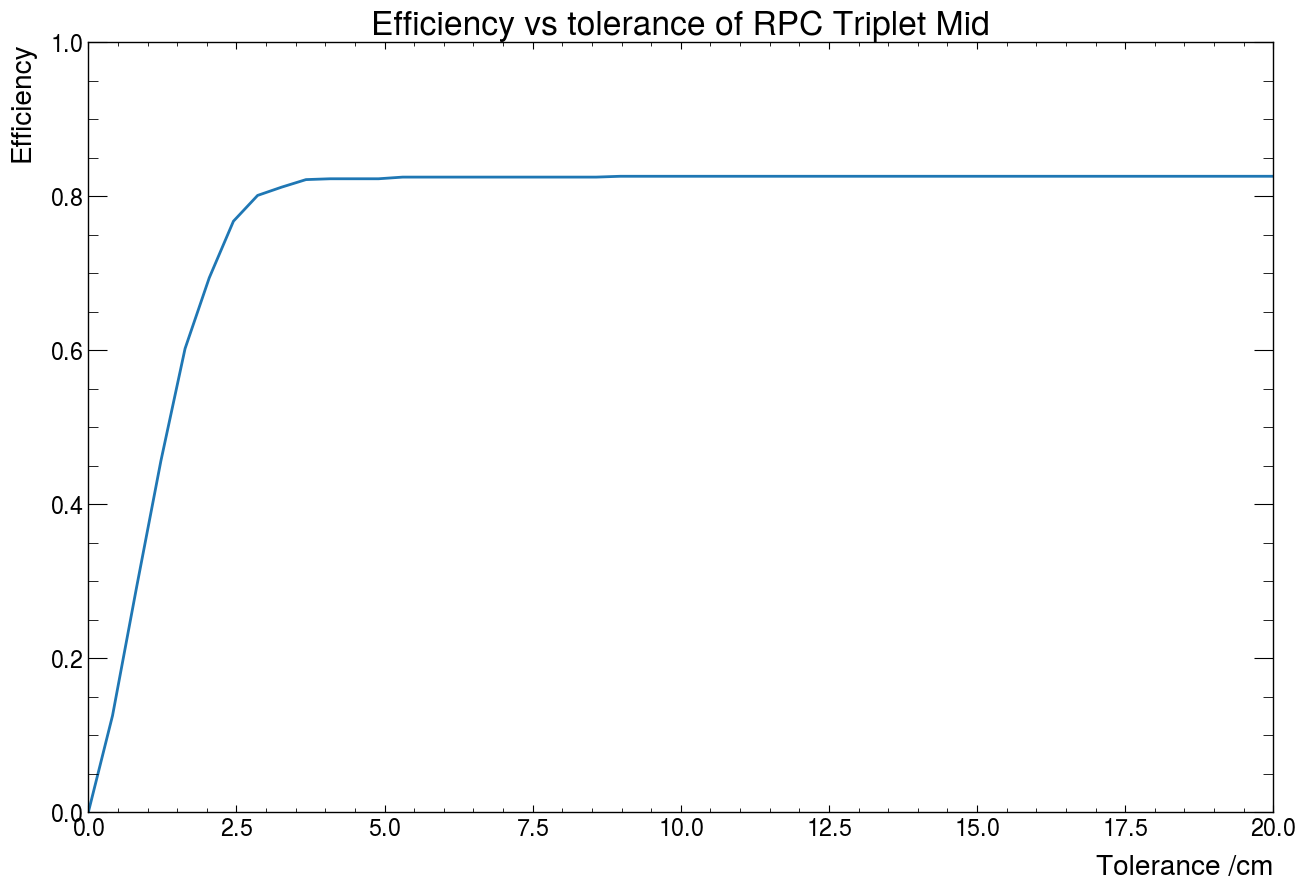

In [58]:
tolerances = np.linspace(0,20,50)

efficiences2 = []

for tol in tolerances:
    print(tol)
    efficiences2.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,1,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences2)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet Mid')

plt.show()

0.0
1081
0
0.40816326530612246
1081
74
0.8163265306122449
1081
311
1.2244897959183674
1081
512
1.6326530612244898
1081
625
2.0408163265306123
1081
689
2.4489795918367347
1081
732
2.857142857142857
1081
746
3.2653061224489797
1081
754
3.673469387755102
1081
754
4.081632653061225
1081
758
4.4897959183673475
1081
758
4.8979591836734695
1081
759
5.3061224489795915
1081
761
5.714285714285714
1081
761
6.122448979591837
1081
761
6.530612244897959
1081
761
6.938775510204081
1081
761
7.346938775510204
1081
762
7.755102040816327
1081
762
8.16326530612245
1081
762
8.571428571428571
1081
762
8.979591836734695
1081
762
9.387755102040817
1081
762
9.795918367346939
1081
762
10.204081632653061
1081
762
10.612244897959183
1081
762
11.020408163265307
1081
762
11.428571428571429
1081
762
11.83673469387755
1081
763
12.244897959183675
1081
763
12.653061224489797
1081
764
13.061224489795919
1081
764
13.46938775510204
1081
764
13.877551020408163
1081
765
14.285714285714286
1081
765
14.693877551020408
1081
76

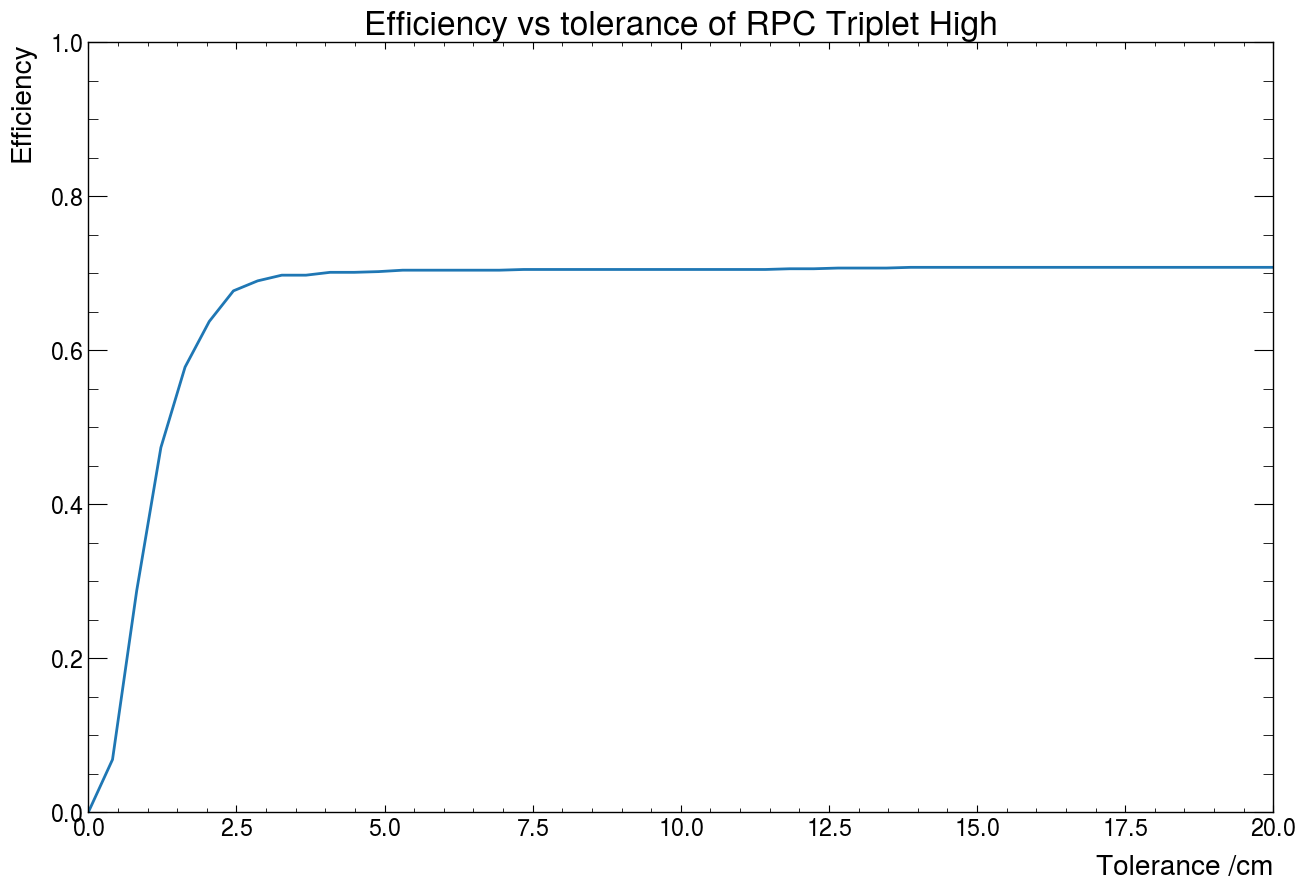

In [59]:
tolerances = np.linspace(0,20,50)

efficiences3 = []

for tol in tolerances:
    print(tol)
    efficiences3.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,2,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences3)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet High')

plt.show()

0.0
1073
0
0.40816326530612246
1073
30
0.8163265306122449
1073
68
1.2244897959183674
1073
136
1.6326530612244898
1073
253
2.0408163265306123
1073
360
2.4489795918367347
1073
464
2.857142857142857
1073
546
3.2653061224489797
1073
616
3.673469387755102
1073
650
4.081632653061225
1073
677
4.4897959183673475
1073
698
4.8979591836734695
1073
719
5.3061224489795915
1073
728
5.714285714285714
1073
735
6.122448979591837
1073
741
6.530612244897959
1073
743
6.938775510204081
1073
743
7.346938775510204
1073
745
7.755102040816327
1073
747
8.16326530612245
1073
751
8.571428571428571
1073
753
8.979591836734695
1073
753
9.387755102040817
1073
754
9.795918367346939
1073
758
10.204081632653061
1073
763
10.612244897959183
1073
764
11.020408163265307
1073
765
11.428571428571429
1073
765
11.83673469387755
1073
765
12.244897959183675
1073
767
12.653061224489797
1073
770
13.061224489795919
1073
771
13.46938775510204
1073
773
13.877551020408163
1073
774
14.285714285714286
1073
774
14.693877551020408
1073
774

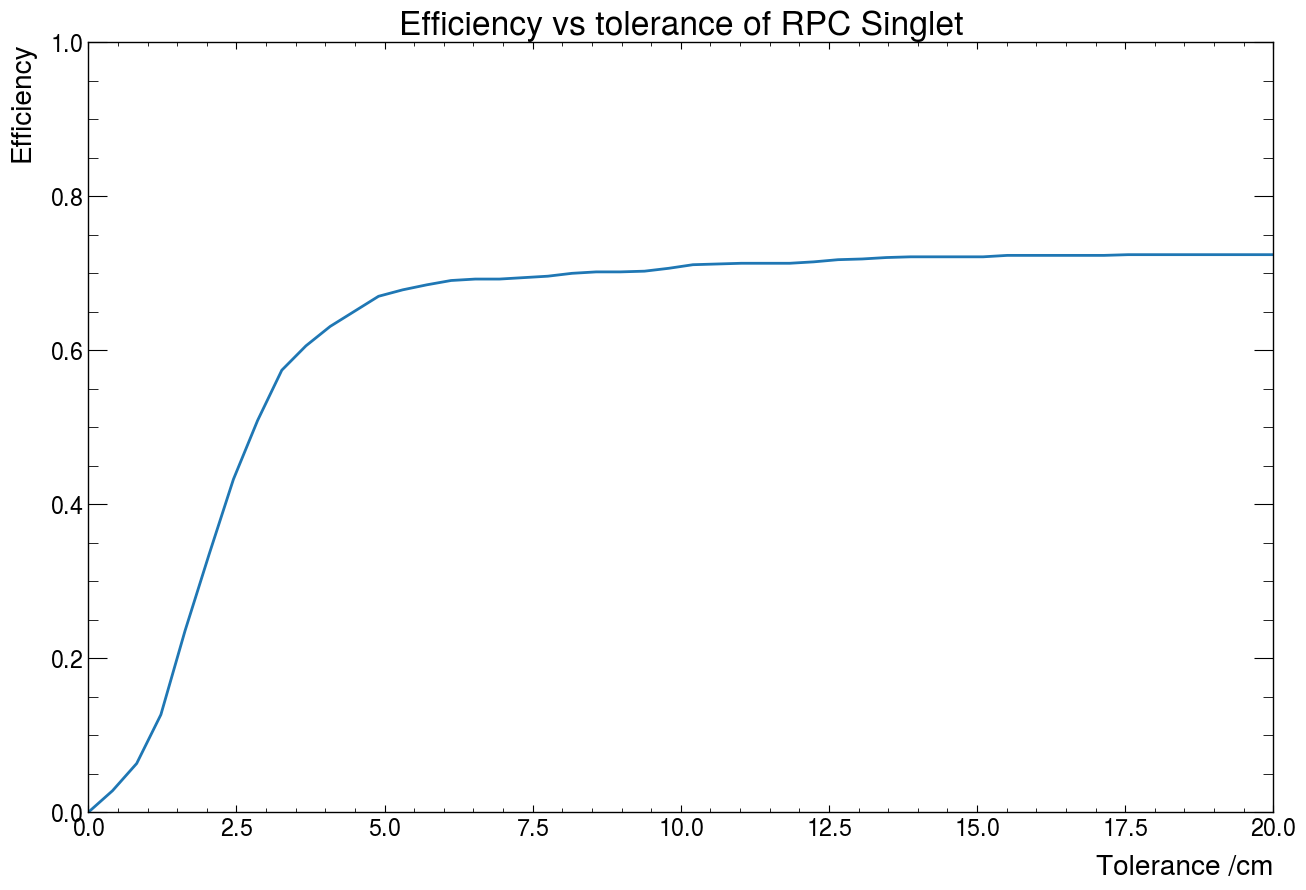

In [60]:
tolerances = np.linspace(0,20,50)

efficiences4 = []

for tol in tolerances:
    print(tol)
    efficiences4.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,3,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences4)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Singlet')

plt.show()

0.0
1685
0
0.40816326530612246
1685
77
0.8163265306122449
1685
193
1.2244897959183674
1685
258
1.6326530612244898
1685
375
2.0408163265306123
1685
473
2.4489795918367347
1685
552
2.857142857142857
1685
595
3.2653061224489797
1685
634
3.673469387755102
1685
663
4.081632653061225
1685
676
4.4897959183673475
1685
686
4.8979591836734695
1685
688
5.3061224489795915
1685
689
5.714285714285714
1685
692
6.122448979591837
1685
693
6.530612244897959
1685
698
6.938775510204081
1685
700
7.346938775510204
1685
701
7.755102040816327
1685
702
8.16326530612245
1685
702
8.571428571428571
1685
705
8.979591836734695
1685
707
9.387755102040817
1685
710
9.795918367346939
1685
711
10.204081632653061
1685
715
10.612244897959183
1685
715
11.020408163265307
1685
715
11.428571428571429
1685
715
11.83673469387755
1685
716
12.244897959183675
1685
716
12.653061224489797
1685
716
13.061224489795919
1685
716
13.46938775510204
1685
716
13.877551020408163
1685
718
14.285714285714286
1685
718
14.693877551020408
1685
71

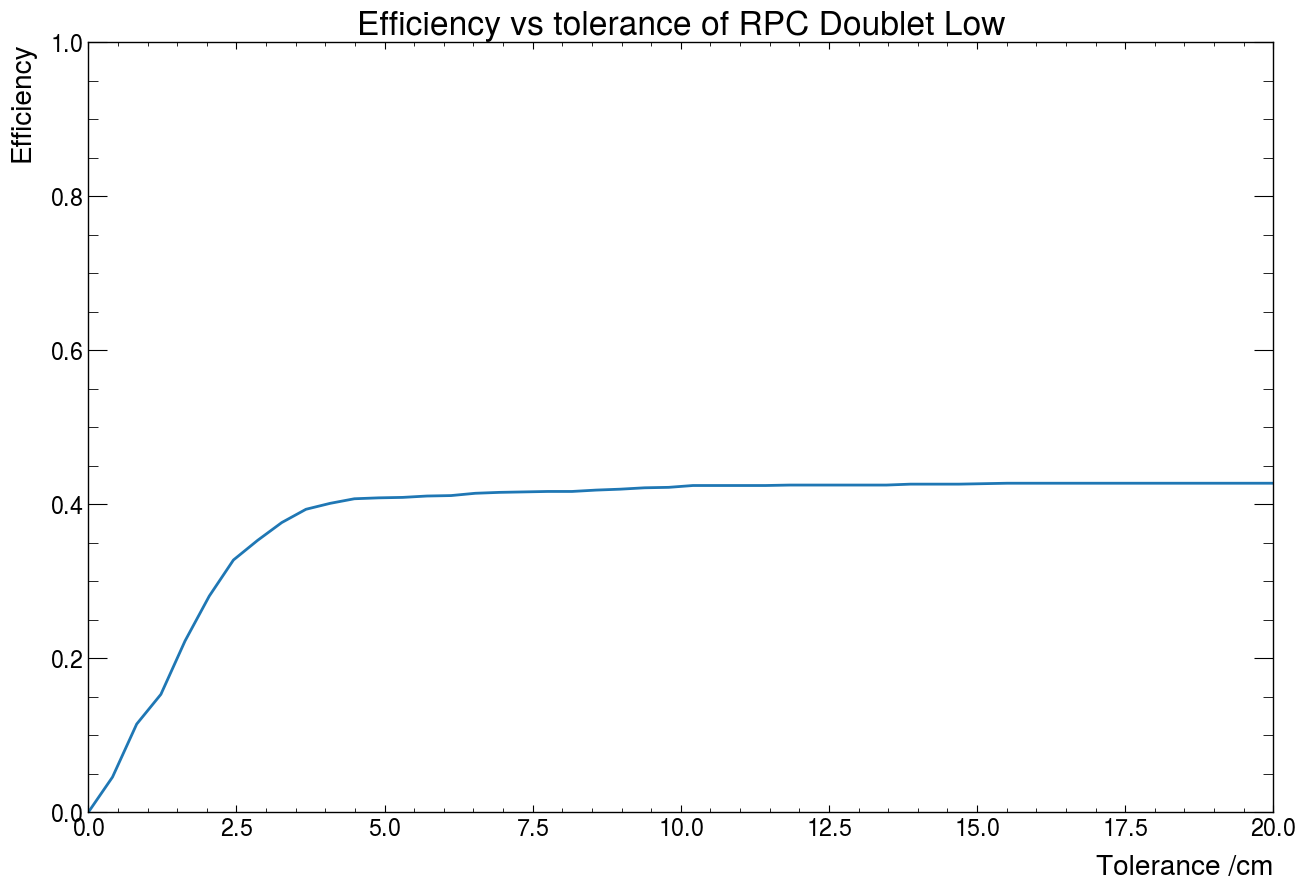

In [62]:
tolerances = np.linspace(0,20,50)

efficiences5 = []

for tol in tolerances:
    print(tol)
    efficiences5.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,4,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences5)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Doublet Low')

plt.show()

0.0
1769
0
0.40816326530612246
1769
45
0.8163265306122449
1769
175
1.2244897959183674
1769
356
1.6326530612244898
1769
474
2.0408163265306123
1769
557
2.4489795918367347
1769
630
2.857142857142857
1769
662
3.2653061224489797
1769
677
3.673469387755102
1769
682
4.081632653061225
1769
686
4.4897959183673475
1769
690
4.8979591836734695
1769
693
5.3061224489795915
1769
694
5.714285714285714
1769
694
6.122448979591837
1769
697
6.530612244897959
1769
697
6.938775510204081
1769
699
7.346938775510204
1769
699
7.755102040816327
1769
703
8.16326530612245
1769
703
8.571428571428571
1769
704
8.979591836734695
1769
706
9.387755102040817
1769
707
9.795918367346939
1769
708
10.204081632653061
1769
708
10.612244897959183
1769
710
11.020408163265307
1769
712
11.428571428571429
1769
712
11.83673469387755
1769
713
12.244897959183675
1769
713
12.653061224489797
1769
715
13.061224489795919
1769
716
13.46938775510204
1769
717
13.877551020408163
1769
718
14.285714285714286
1769
718
14.693877551020408
1769
71

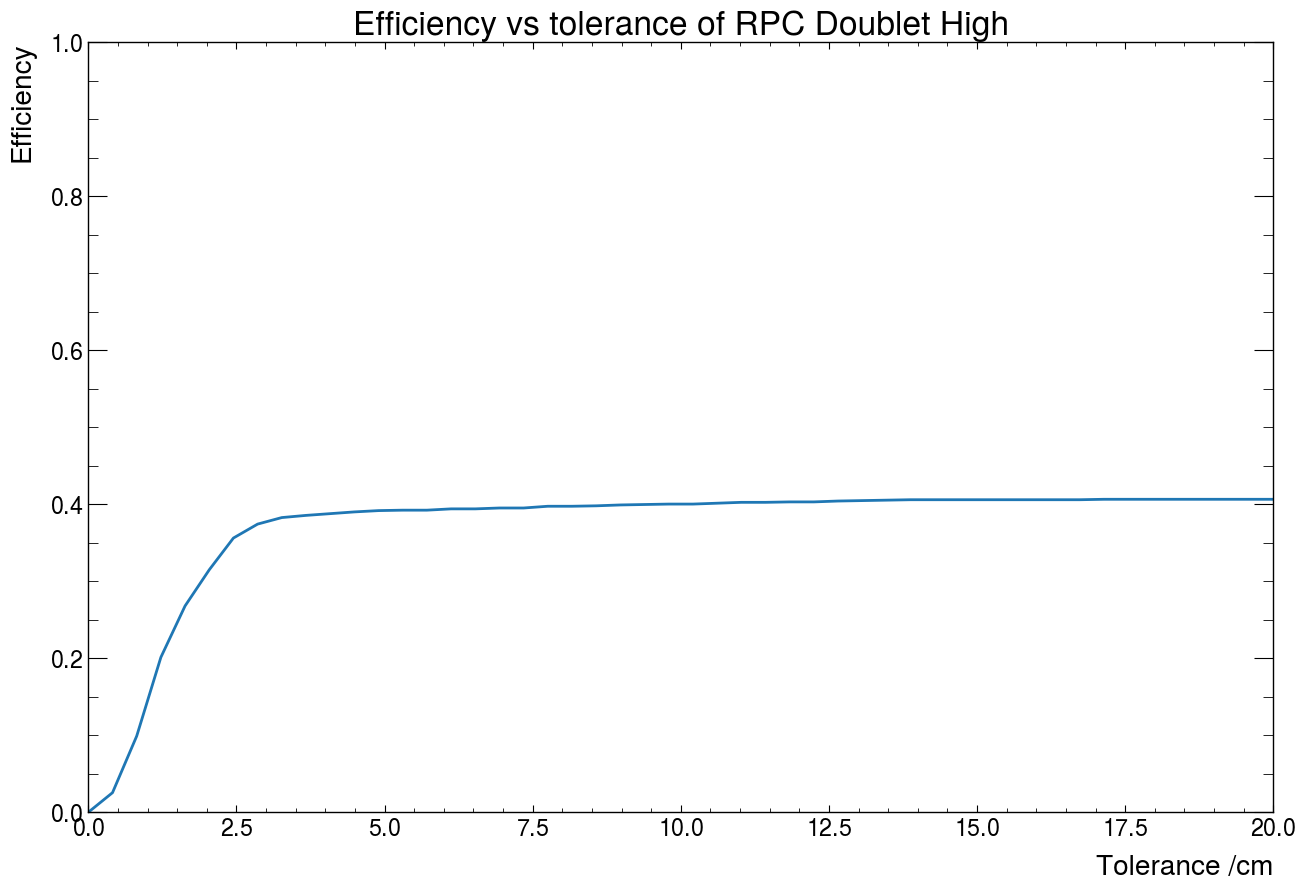

In [61]:
tolerances = np.linspace(0,20,50)

efficiences6 = []

for tol in tolerances:
    print(tol)
    efficiences6.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,5,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences6)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Doublet High')

plt.show()

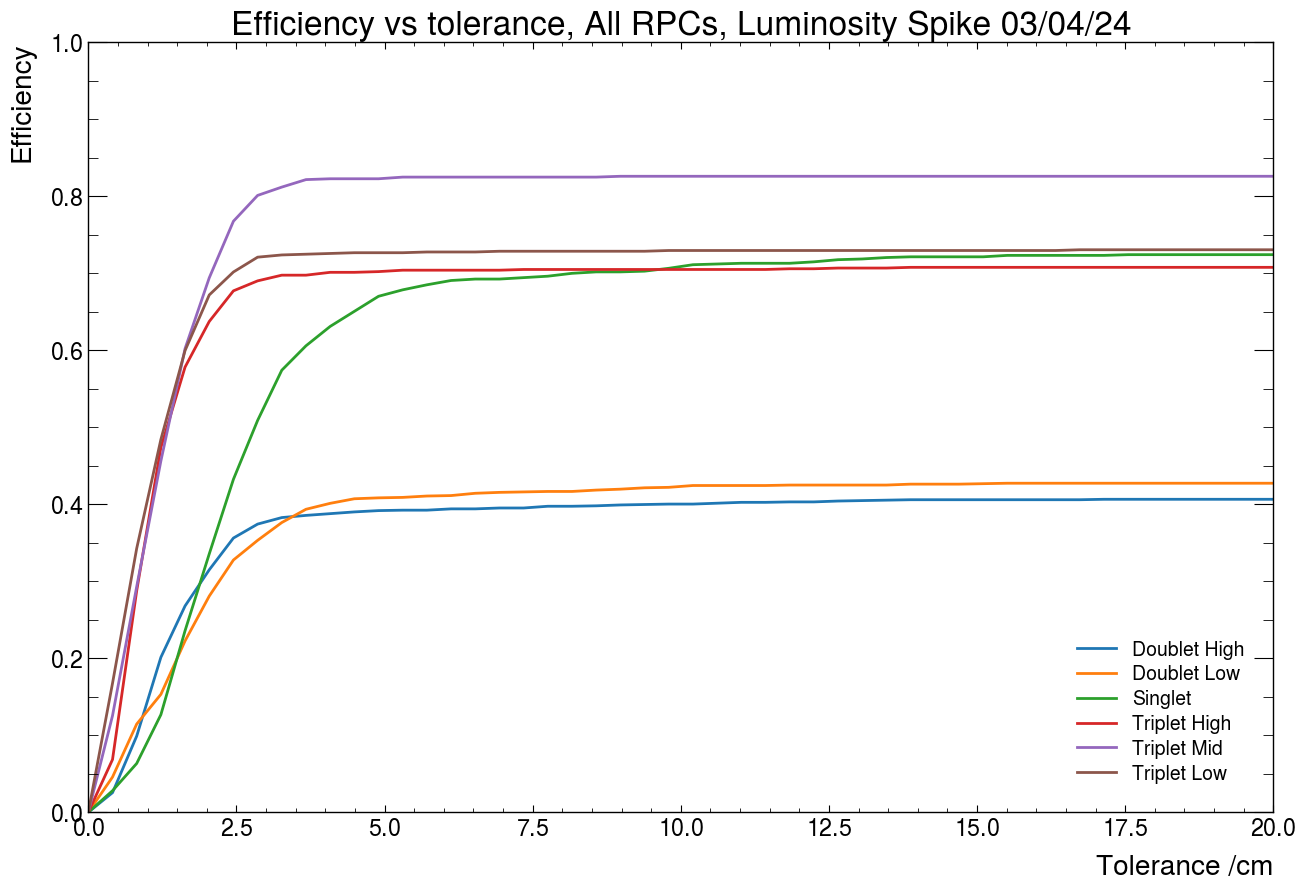

In [63]:
plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences6, label= 'Doublet High')
plt.plot(tolerances, efficiences5, label= 'Doublet Low')
plt.plot(tolerances, efficiences4, label= 'Singlet')
plt.plot(tolerances, efficiences3, label= 'Triplet High')
plt.plot(tolerances, efficiences2, label= 'Triplet Mid')
plt.plot(tolerances, efficiences1, label= 'Triplet Low')
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')

plt.legend()
plt.ylim(0,1)

plt.title('Efficiency vs tolerance, All RPCs, Luminosity Spike 03/04/24')

plt.show()

Cosmics from 3 hour run over a month ago

In [29]:
data2 = ANT.importDatafile(current_directory+"\\ProAnubisData\\threeHourRun_24_3_1.h5")

etaHits2, phiHits2 = ANT.divideHitCountsByRPC_Timed(data2)

#ANT.importDatafile is from original scripts. ANT.divideHitCountsByRPC_Timed() is modified from original scripts. All other functions are new.

#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_3hrs_cosmics = ANT.FindCoincidentHits(etaHits2,phiHits2,15)

#Spatial Clustering
coincident_hits_3hrs_clustered = ANT.cluster(coincident_hits_3hrs_cosmics)

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0

0.0
1077
0
0.40816326530612246
1077
125
0.8163265306122449
1077
273
1.2244897959183674
1077
430
1.6326530612244898
1077
556
2.0408163265306123
1077
628
2.4489795918367347
1077
667
2.857142857142857
1077
689
3.2653061224489797
1077
702
3.673469387755102
1077
710
4.081632653061225
1077
714
4.4897959183673475
1077
716
4.8979591836734695
1077
719
5.3061224489795915
1077
720
5.714285714285714
1077
721
6.122448979591837
1077
724
6.530612244897959
1077
724
6.938775510204081
1077
724
7.346938775510204
1077
724
7.755102040816327
1077
724
8.16326530612245
1077
726
8.571428571428571
1077
726
8.979591836734695
1077
726
9.387755102040817
1077
727
9.795918367346939
1077
727
10.204081632653061
1077
728
10.612244897959183
1077
729
11.020408163265307
1077
729
11.428571428571429
1077
729
11.83673469387755
1077
729
12.244897959183675
1077
729
12.653061224489797
1077
730
13.061224489795919
1077
730
13.46938775510204
1077
730
13.877551020408163
1077
730
14.285714285714286
1077
730
14.693877551020408
1077
7

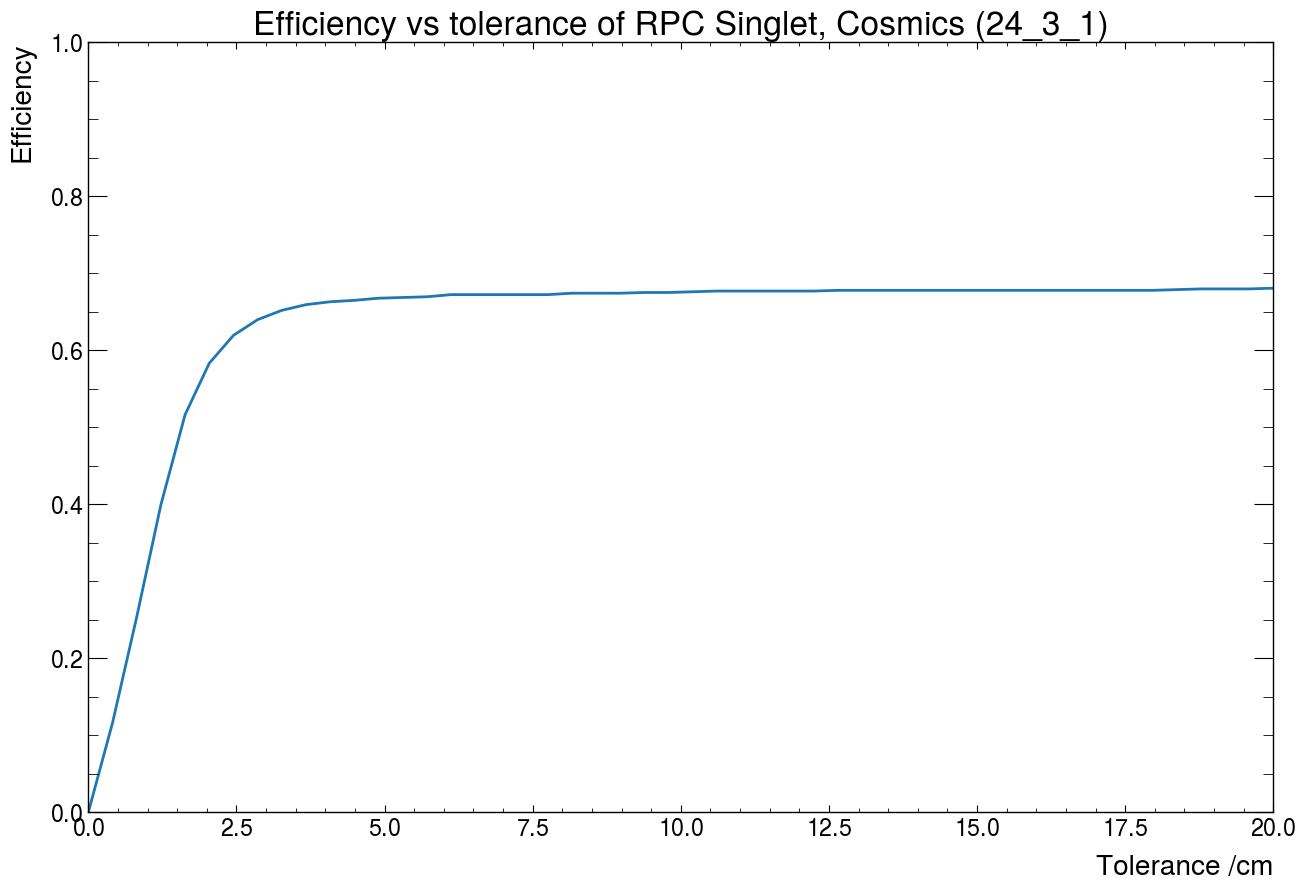

In [31]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics1 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics1.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,0,tol))

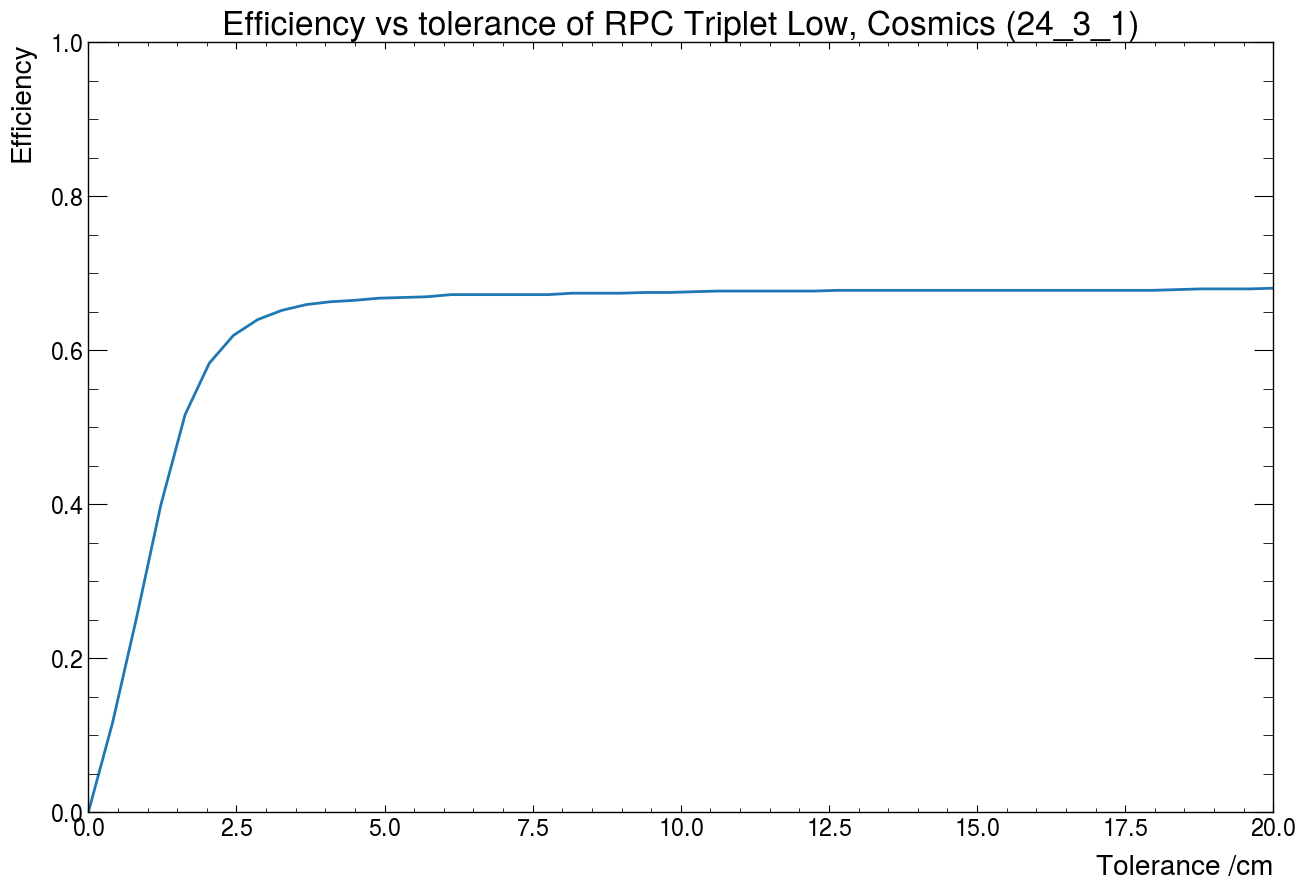

In [32]:

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics1)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet Low, Cosmics (24_3_1)')

plt.show()

0.0
981
0
0.40816326530612246
981
95
0.8163265306122449
981
246
1.2244897959183674
981
394
1.6326530612244898
981
516
2.0408163265306123
981
614
2.4489795918367347
981
672
2.857142857142857
981
703
3.2653061224489797
981
716
3.673469387755102
981
722
4.081632653061225
981
726
4.4897959183673475
981
730
4.8979591836734695
981
731
5.3061224489795915
981
733
5.714285714285714
981
736
6.122448979591837
981
736
6.530612244897959
981
736
6.938775510204081
981
737
7.346938775510204
981
737
7.755102040816327
981
737
8.16326530612245
981
737
8.571428571428571
981
738
8.979591836734695
981
738
9.387755102040817
981
739
9.795918367346939
981
740
10.204081632653061
981
740
10.612244897959183
981
741
11.020408163265307
981
741
11.428571428571429
981
741
11.83673469387755
981
741
12.244897959183675
981
741
12.653061224489797
981
741
13.061224489795919
981
741
13.46938775510204
981
742
13.877551020408163
981
742
14.285714285714286
981
742
14.693877551020408
981
743
15.10204081632653
981
743
15.510204

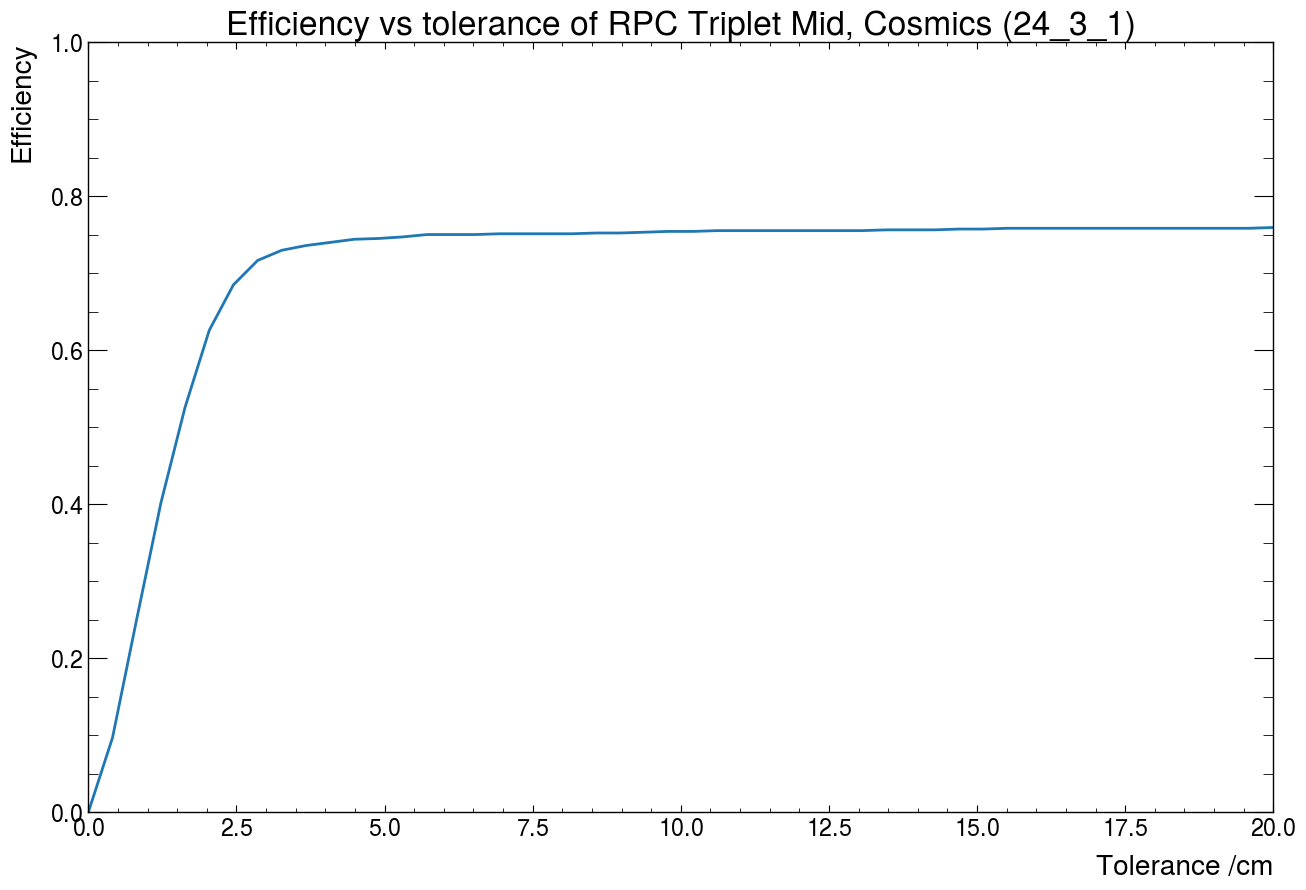

In [34]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics2 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics2.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,1,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics2)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet Mid, Cosmics (24_3_1)')

plt.show()

0.0
1121
0
0.40816326530612246
1121
82
0.8163265306122449
1121
237
1.2244897959183674
1121
433
1.6326530612244898
1121
577
2.0408163265306123
1121
659
2.4489795918367347
1121
694
2.857142857142857
1121
714
3.2653061224489797
1121
726
3.673469387755102
1121
730
4.081632653061225
1121
732
4.4897959183673475
1121
733
4.8979591836734695
1121
734
5.3061224489795915
1121
735
5.714285714285714
1121
736
6.122448979591837
1121
736
6.530612244897959
1121
736
6.938775510204081
1121
737
7.346938775510204
1121
738
7.755102040816327
1121
738
8.16326530612245
1121
738
8.571428571428571
1121
738
8.979591836734695
1121
738
9.387755102040817
1121
738
9.795918367346939
1121
739
10.204081632653061
1121
740
10.612244897959183
1121
741
11.020408163265307
1121
741
11.428571428571429
1121
741
11.83673469387755
1121
742
12.244897959183675
1121
742
12.653061224489797
1121
742
13.061224489795919
1121
743
13.46938775510204
1121
743
13.877551020408163
1121
743
14.285714285714286
1121
743
14.693877551020408
1121
74

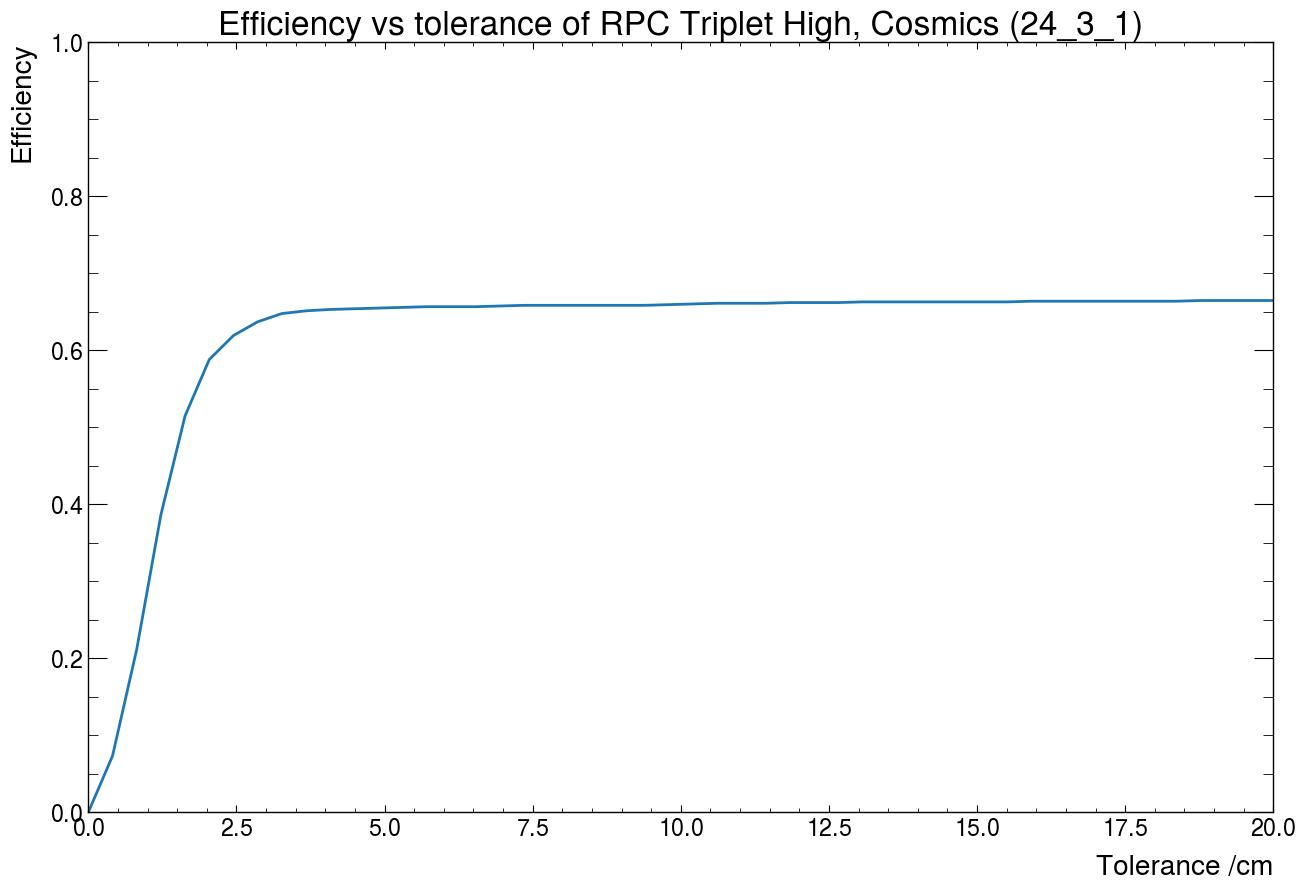

In [35]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics3 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics3.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,2,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics3)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet High, Cosmics (24_3_1)')

plt.show()

0.0
1086
0
0.40816326530612246
1086
26
0.8163265306122449
1086
66
1.2244897959183674
1086
114
1.6326530612244898
1086
205
2.0408163265306123
1086
291
2.4489795918367347
1086
377
2.857142857142857
1086
462
3.2653061224489797
1086
525
3.673469387755102
1086
582
4.081632653061225
1086
625
4.4897959183673475
1086
661
4.8979591836734695
1086
682
5.3061224489795915
1086
696
5.714285714285714
1086
706
6.122448979591837
1086
714
6.530612244897959
1086
719
6.938775510204081
1086
722
7.346938775510204
1086
724
7.755102040816327
1086
725
8.16326530612245
1086
726
8.571428571428571
1086
728
8.979591836734695
1086
730
9.387755102040817
1086
732
9.795918367346939
1086
734
10.204081632653061
1086
734
10.612244897959183
1086
734
11.020408163265307
1086
734
11.428571428571429
1086
736
11.83673469387755
1086
736
12.244897959183675
1086
740
12.653061224489797
1086
743
13.061224489795919
1086
743
13.46938775510204
1086
743
13.877551020408163
1086
743
14.285714285714286
1086
744
14.693877551020408
1086
745

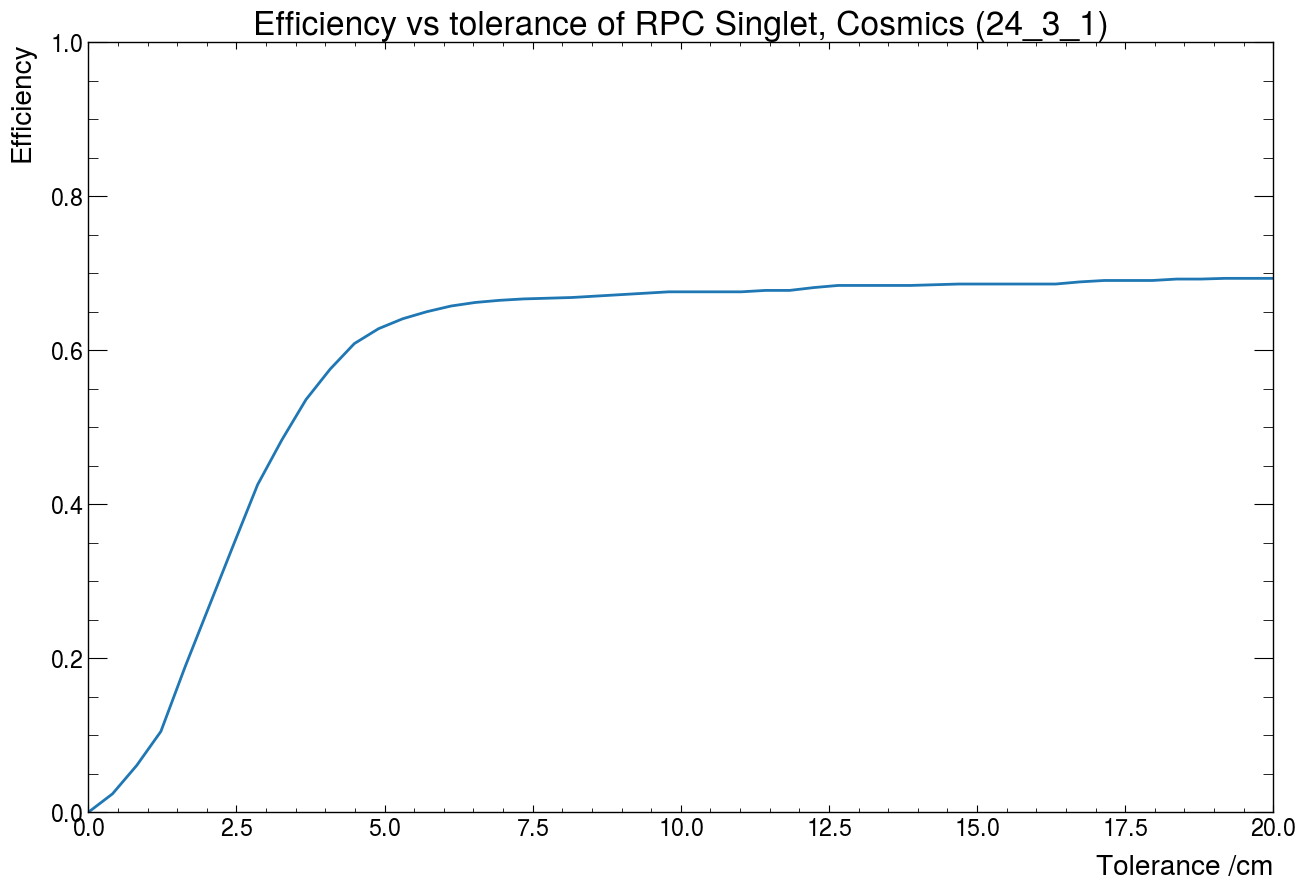

In [37]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics4 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics4.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,3,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics4)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Singlet, Cosmics (24_3_1)')

plt.show()

0.0
1041
0
0.40816326530612246
1041
70
0.8163265306122449
1041
162
1.2244897959183674
1041
234
1.6326530612244898
1041
346
2.0408163265306123
1041
459
2.4489795918367347
1041
529
2.857142857142857
1041
580
3.2653061224489797
1041
614
3.673469387755102
1041
646
4.081632653061225
1041
659
4.4897959183673475
1041
667
4.8979591836734695
1041
671
5.3061224489795915
1041
672
5.714285714285714
1041
675
6.122448979591837
1041
676
6.530612244897959
1041
679
6.938775510204081
1041
680
7.346938775510204
1041
683
7.755102040816327
1041
686
8.16326530612245
1041
686
8.571428571428571
1041
689
8.979591836734695
1041
693
9.387755102040817
1041
694
9.795918367346939
1041
694
10.204081632653061
1041
695
10.612244897959183
1041
696
11.020408163265307
1041
697
11.428571428571429
1041
698
11.83673469387755
1041
698
12.244897959183675
1041
699
12.653061224489797
1041
700
13.061224489795919
1041
700
13.46938775510204
1041
701
13.877551020408163
1041
702
14.285714285714286
1041
703
14.693877551020408
1041
70

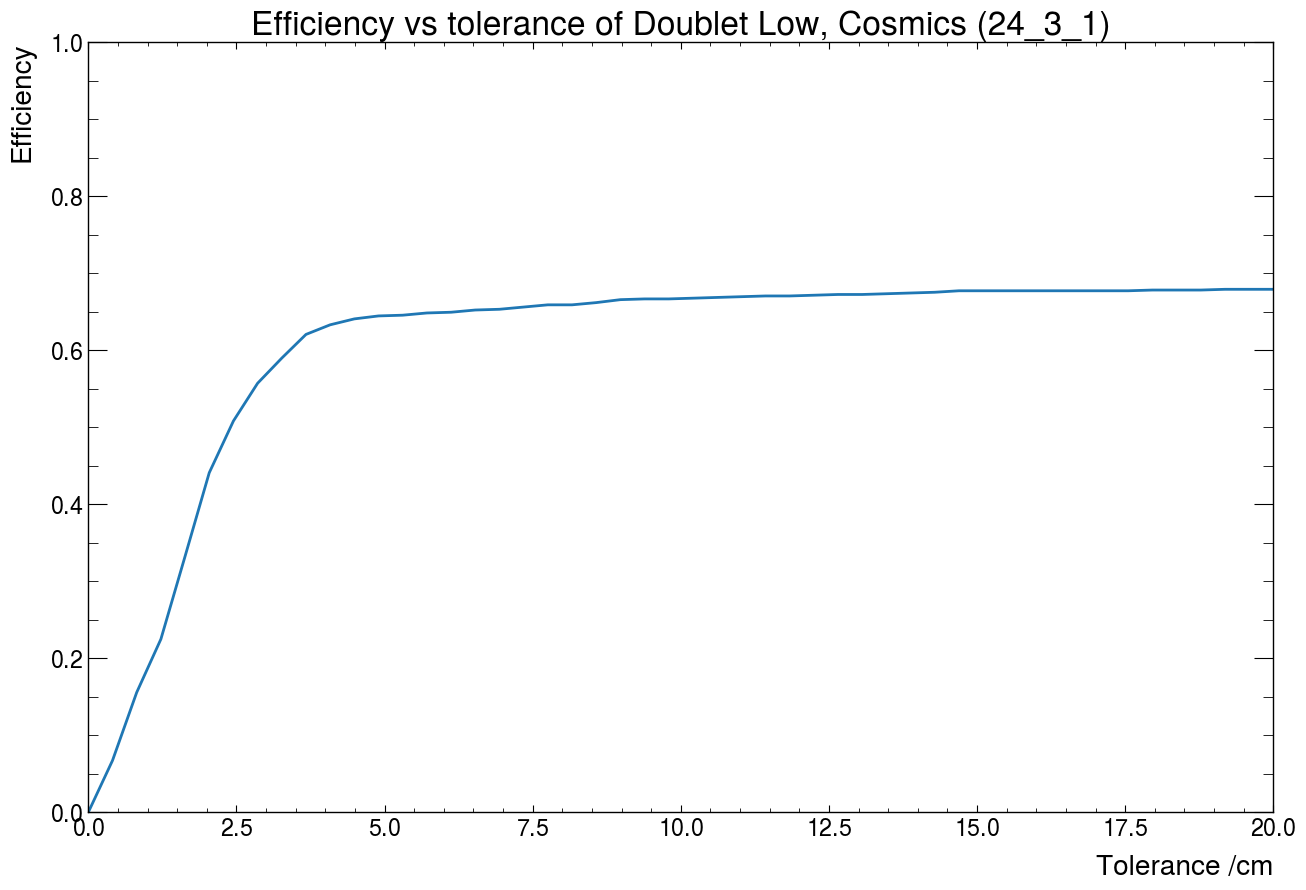

In [38]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics5 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics5.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,4,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics5)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of Doublet Low, Cosmics (24_3_1)')

plt.show()

0.0
954
0
0.40816326530612246
954
49
0.8163265306122449
954
165
1.2244897959183674
954
287
1.6326530612244898
954
430
2.0408163265306123
954
525
2.4489795918367347
954
605
2.857142857142857
954
640
3.2653061224489797
954
661
3.673469387755102
954
669
4.081632653061225
954
674
4.4897959183673475
954
676
4.8979591836734695
954
677
5.3061224489795915
954
678
5.714285714285714
954
682
6.122448979591837
954
682
6.530612244897959
954
684
6.938775510204081
954
687
7.346938775510204
954
688
7.755102040816327
954
689
8.16326530612245
954
690
8.571428571428571
954
690
8.979591836734695
954
690
9.387755102040817
954
692
9.795918367346939
954
692
10.204081632653061
954
692
10.612244897959183
954
694
11.020408163265307
954
695
11.428571428571429
954
696
11.83673469387755
954
698
12.244897959183675
954
700
12.653061224489797
954
703
13.061224489795919
954
703
13.46938775510204
954
703
13.877551020408163
954
704
14.285714285714286
954
704
14.693877551020408
954
704
15.10204081632653
954
704
15.510204

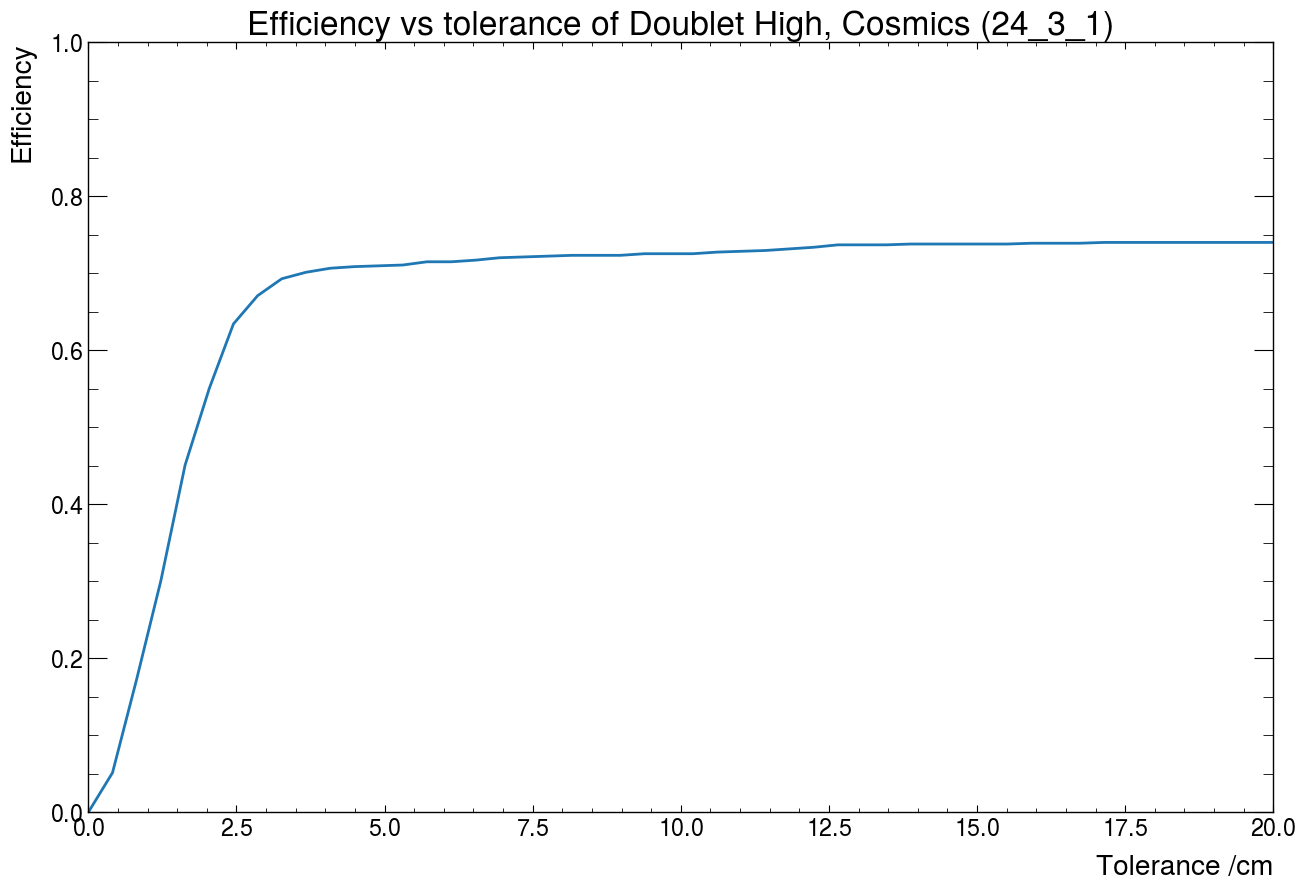

In [40]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics6 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics6.append(calc_efficiency_RPC(coincident_hits_3hrs_clustered,5,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics6)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of Doublet High, Cosmics (24_3_1)')

plt.show()

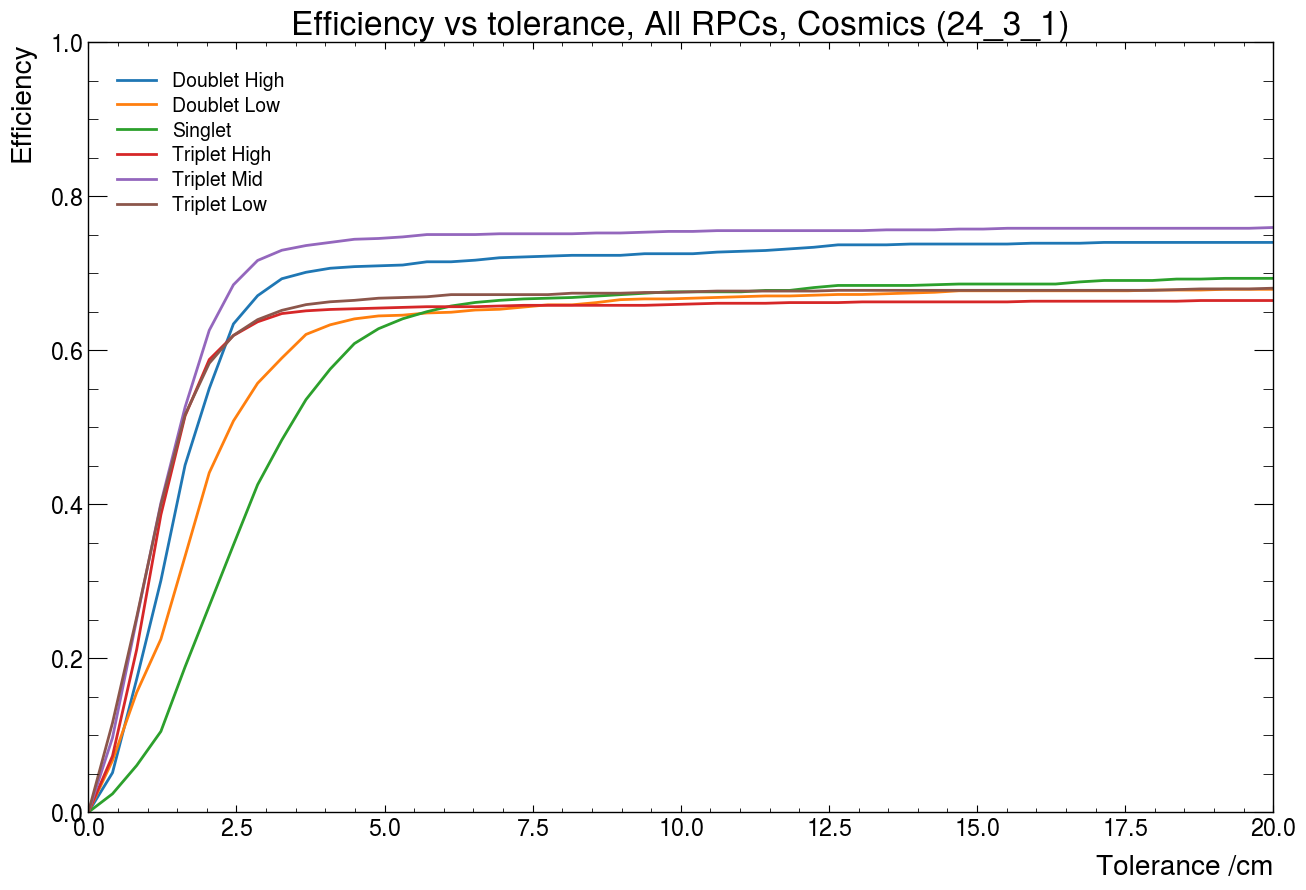

In [42]:
plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics6, label= 'Doublet High')
plt.plot(tolerances, efficiences_cosmics5, label= 'Doublet Low')
plt.plot(tolerances, efficiences_cosmics4, label= 'Singlet')
plt.plot(tolerances, efficiences_cosmics3, label= 'Triplet High')
plt.plot(tolerances, efficiences_cosmics2, label= 'Triplet Mid')
plt.plot(tolerances, efficiences_cosmics1, label= 'Triplet Low')
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')

plt.legend()
plt.ylim(0,1)

plt.title('Efficiency vs tolerance, All RPCs, Cosmics (24_3_1)')

plt.show()

Check w/ cosmics 2 hours after ATLAS luminosity Spike

In [43]:
Cosmics = ANT.importFromHDF5File(current_directory+"\\ProAnubisData\\ATLAS LUMINOSITY\\proAnubis_240403_1427_cosmics.h5")

data_cosmics = [sublist[:55489] for sublist in Cosmics]

c_etaHits, c_phiHits = ANT.divideHitCountsByRPC_Timed(data_cosmics)

#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_cosmics = ANT.FindCoincidentHits(c_etaHits,c_phiHits,15)

#Spatial Clustering
coincident_hits_cosmics_clustered = ANT.cluster(coincident_hits_cosmics)

print(len(coincident_hits_cosmics_clustered))

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1

In [45]:
def importFromHDF5File(filename):

    inputHDF5 = h5py.File(filename, 'r')  

    data = [[] for _ in range(5)] 

    for event in inputHDF5['data']:

        tdc = event['tdc'] - 60928

        time_ms = event['time_ms']

        thisEvent = {'time_ms': time_ms, 'hits': []}

        for hit in event['words']:

            thisEvent['hits'].append(hit)

        data[tdc].append(thisEvent)

    return data

In [46]:
data_cosmics_test = importFromHDF5File(current_directory+"\\ProAnubisData\\ATLAS LUMINOSITY\\proAnubis_240403_1427_cosmics.h5")

In [47]:
print(data_cosmics_test[0][0])

{'time_ms': 1712147265, 'hits': [135266557, 152043772, 1209008368, 1745879298, 1762656511]}


In [48]:
for idx, i in enumerate(data_cosmics_test[0]):

    if i['time_ms'] >= 1712158065:

        print(idx)

        break

83169


In [49]:
for j in range(5):
    for i in range(83169):
       # print(data_cosmics[j][i]['time_ms'])
        if data_cosmics_test[j][i]['time_ms'] < 0:
            print("negative timestep found")
            break

Safe to use!

In [50]:

data_cosmics = [sublist[:83169] for sublist in Cosmics]

c_etaHits, c_phiHits = ANT.divideHitCountsByRPC_Timed(data_cosmics)

#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_cosmics = ANT.FindCoincidentHits(c_etaHits,c_phiHits,15)

#Spatial Clustering
coincident_hits_cosmics_clustered = ANT.cluster(coincident_hits_cosmics)

print(len(coincident_hits_cosmics_clustered))

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0

0.0
419
0
0.40816326530612246
419
46
0.8163265306122449
419
116
1.2244897959183674
419
181
1.6326530612244898
419
224
2.0408163265306123
419
265
2.4489795918367347
419
285
2.857142857142857
419
287
3.2653061224489797
419
290
3.673469387755102
419
291
4.081632653061225
419
292
4.4897959183673475
419
293
4.8979591836734695
419
293
5.3061224489795915
419
293
5.714285714285714
419
293
6.122448979591837
419
293
6.530612244897959
419
293
6.938775510204081
419
293
7.346938775510204
419
293
7.755102040816327
419
293
8.16326530612245
419
293
8.571428571428571
419
293
8.979591836734695
419
293
9.387755102040817
419
293
9.795918367346939
419
293
10.204081632653061
419
293
10.612244897959183
419
293
11.020408163265307
419
293
11.428571428571429
419
293
11.83673469387755
419
293
12.244897959183675
419
293
12.653061224489797
419
293
13.061224489795919
419
293
13.46938775510204
419
293
13.877551020408163
419
293
14.285714285714286
419
293
14.693877551020408
419
293
15.10204081632653
419
293
15.510204

Text(0.5, 1.0, 'Efficiency vs tolerance of Triplet Low, Cosmics 03/04/24')

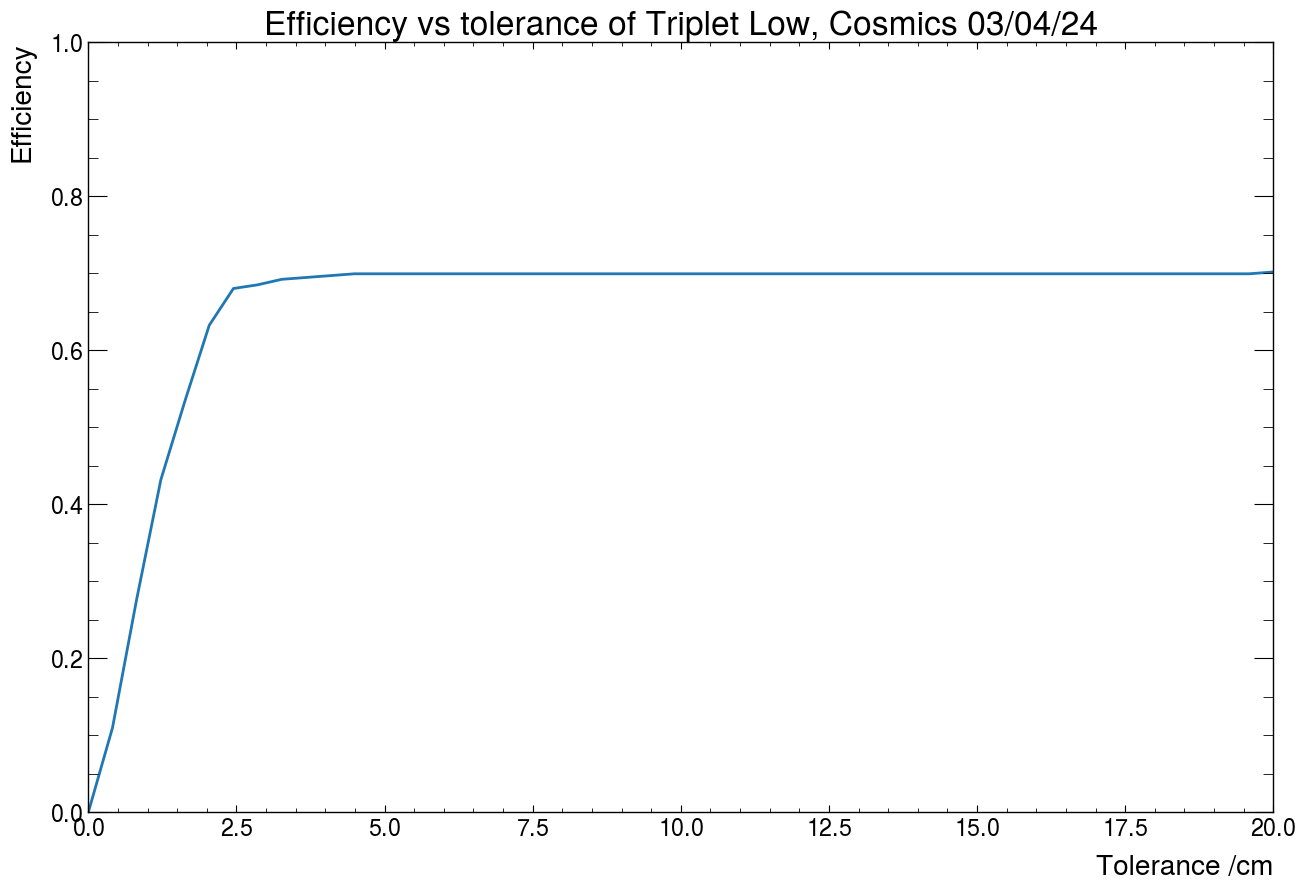

In [51]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics2_1 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics2_1.append(calc_efficiency_RPC(coincident_hits_cosmics_clustered,0,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics2_1)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of Triplet Low, Cosmics 03/04/24')


0.0
351
0
0.40816326530612246
351
43
0.8163265306122449
351
102
1.2244897959183674
351
161
1.6326530612244898
351
211
2.0408163265306123
351
253
2.4489795918367347
351
278
2.857142857142857
351
286
3.2653061224489797
351
288
3.673469387755102
351
291
4.081632653061225
351
291
4.4897959183673475
351
293
4.8979591836734695
351
293
5.3061224489795915
351
293
5.714285714285714
351
293
6.122448979591837
351
293
6.530612244897959
351
293
6.938775510204081
351
293
7.346938775510204
351
293
7.755102040816327
351
293
8.16326530612245
351
293
8.571428571428571
351
293
8.979591836734695
351
293
9.387755102040817
351
293
9.795918367346939
351
293
10.204081632653061
351
293
10.612244897959183
351
293
11.020408163265307
351
293
11.428571428571429
351
293
11.83673469387755
351
293
12.244897959183675
351
293
12.653061224489797
351
293
13.061224489795919
351
293
13.46938775510204
351
294
13.877551020408163
351
294
14.285714285714286
351
294
14.693877551020408
351
294
15.10204081632653
351
294
15.510204

Text(0.5, 1.0, 'Efficiency vs tolerance of Triplet Mid, Cosmics 03/04/24')

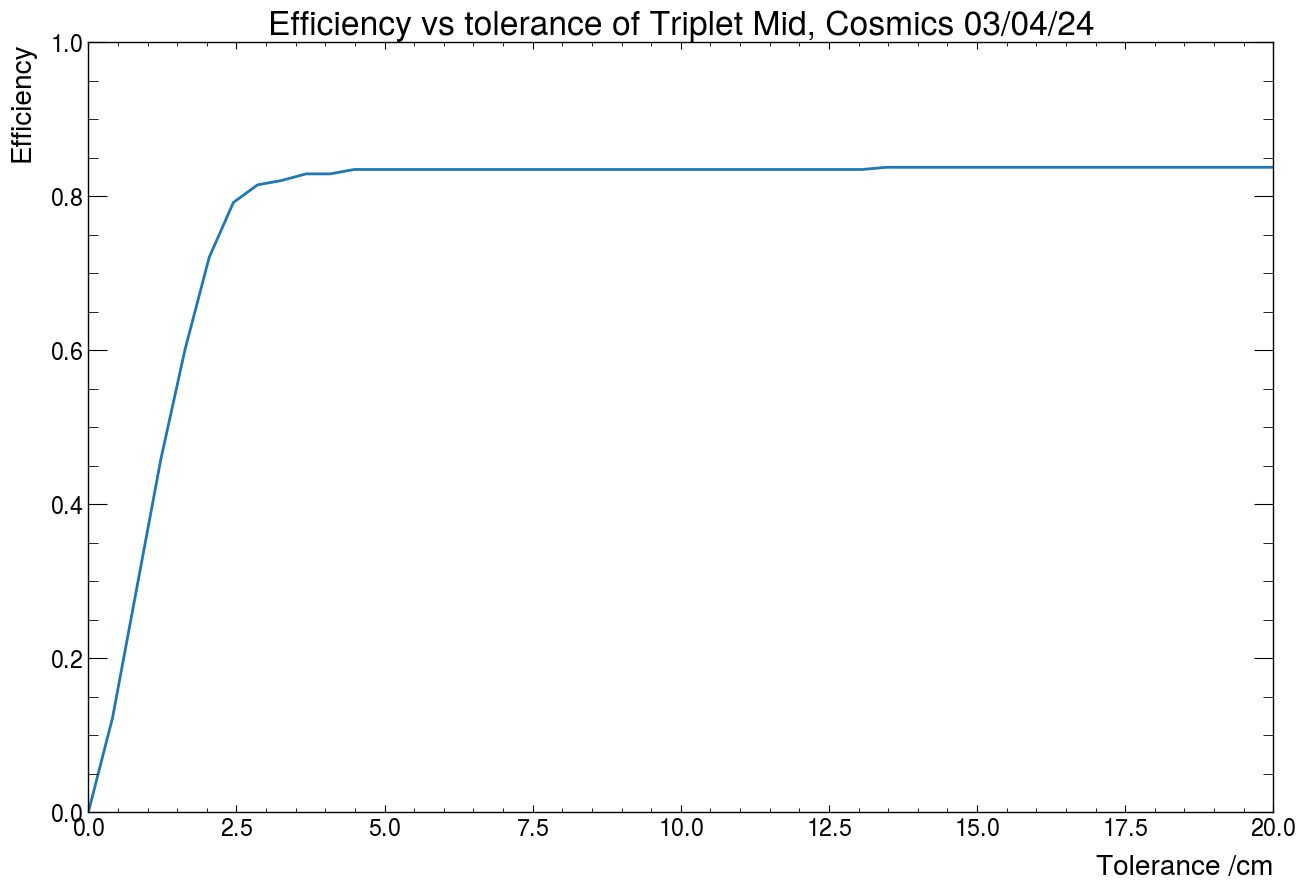

In [52]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics2_2 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics2_2.append(calc_efficiency_RPC(coincident_hits_cosmics_clustered,1,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics2_2)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of Triplet Mid, Cosmics 03/04/24')


0.0
400
0
0.40816326530612246
400
26
0.8163265306122449
400
97
1.2244897959183674
400
175
1.6326530612244898
400
220
2.0408163265306123
400
256
2.4489795918367347
400
278
2.857142857142857
400
288
3.2653061224489797
400
290
3.673469387755102
400
290
4.081632653061225
400
291
4.4897959183673475
400
292
4.8979591836734695
400
292
5.3061224489795915
400
293
5.714285714285714
400
293
6.122448979591837
400
293
6.530612244897959
400
293
6.938775510204081
400
293
7.346938775510204
400
293
7.755102040816327
400
293
8.16326530612245
400
293
8.571428571428571
400
293
8.979591836734695
400
293
9.387755102040817
400
293
9.795918367346939
400
293
10.204081632653061
400
293
10.612244897959183
400
293
11.020408163265307
400
293
11.428571428571429
400
293
11.83673469387755
400
293
12.244897959183675
400
293
12.653061224489797
400
293
13.061224489795919
400
293
13.46938775510204
400
293
13.877551020408163
400
293
14.285714285714286
400
293
14.693877551020408
400
293
15.10204081632653
400
293
15.5102040

Text(0.5, 1.0, 'Efficiency vs tolerance of Triplet High, Cosmics 03/04/24')

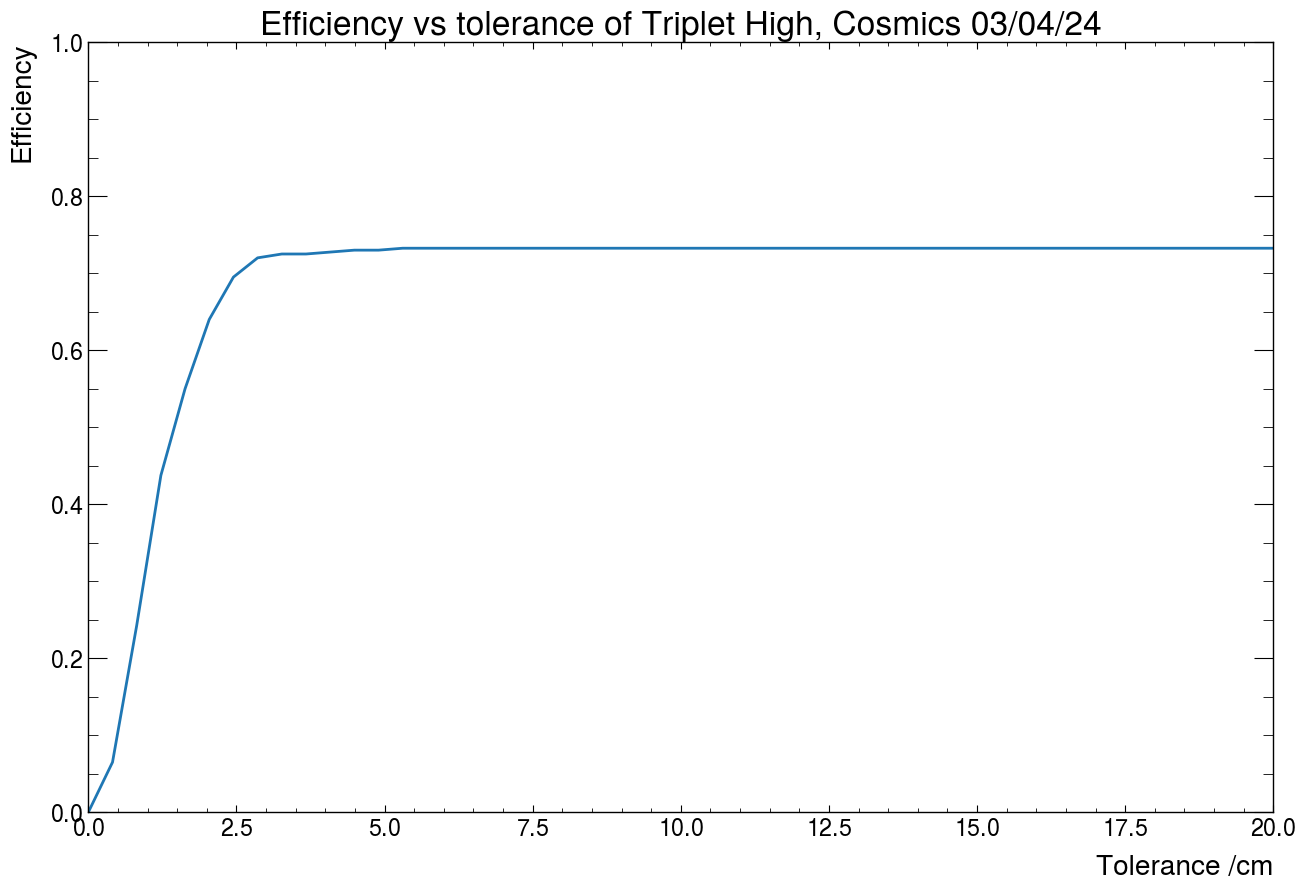

In [53]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics2_3 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics2_3.append(calc_efficiency_RPC(coincident_hits_cosmics_clustered,2,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics2_3)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of Triplet High, Cosmics 03/04/24')


0.0
446
0
0.40816326530612246
446
10
0.8163265306122449
446
22
1.2244897959183674
446
39
1.6326530612244898
446
81
2.0408163265306123
446
118
2.4489795918367347
446
151
2.857142857142857
446
176
3.2653061224489797
446
207
3.673469387755102
446
225
4.081632653061225
446
241
4.4897959183673475
446
256
4.8979591836734695
446
266
5.3061224489795915
446
272
5.714285714285714
446
278
6.122448979591837
446
278
6.530612244897959
446
281
6.938775510204081
446
282
7.346938775510204
446
283
7.755102040816327
446
284
8.16326530612245
446
285
8.571428571428571
446
285
8.979591836734695
446
285
9.387755102040817
446
285
9.795918367346939
446
285
10.204081632653061
446
285
10.612244897959183
446
286
11.020408163265307
446
288
11.428571428571429
446
290
11.83673469387755
446
293
12.244897959183675
446
295
12.653061224489797
446
295
13.061224489795919
446
295
13.46938775510204
446
295
13.877551020408163
446
296
14.285714285714286
446
296
14.693877551020408
446
296
15.10204081632653
446
296
15.510204081

Text(0.5, 1.0, 'Efficiency vs tolerance of RPC Singlet, Cosmics 03/04/24')

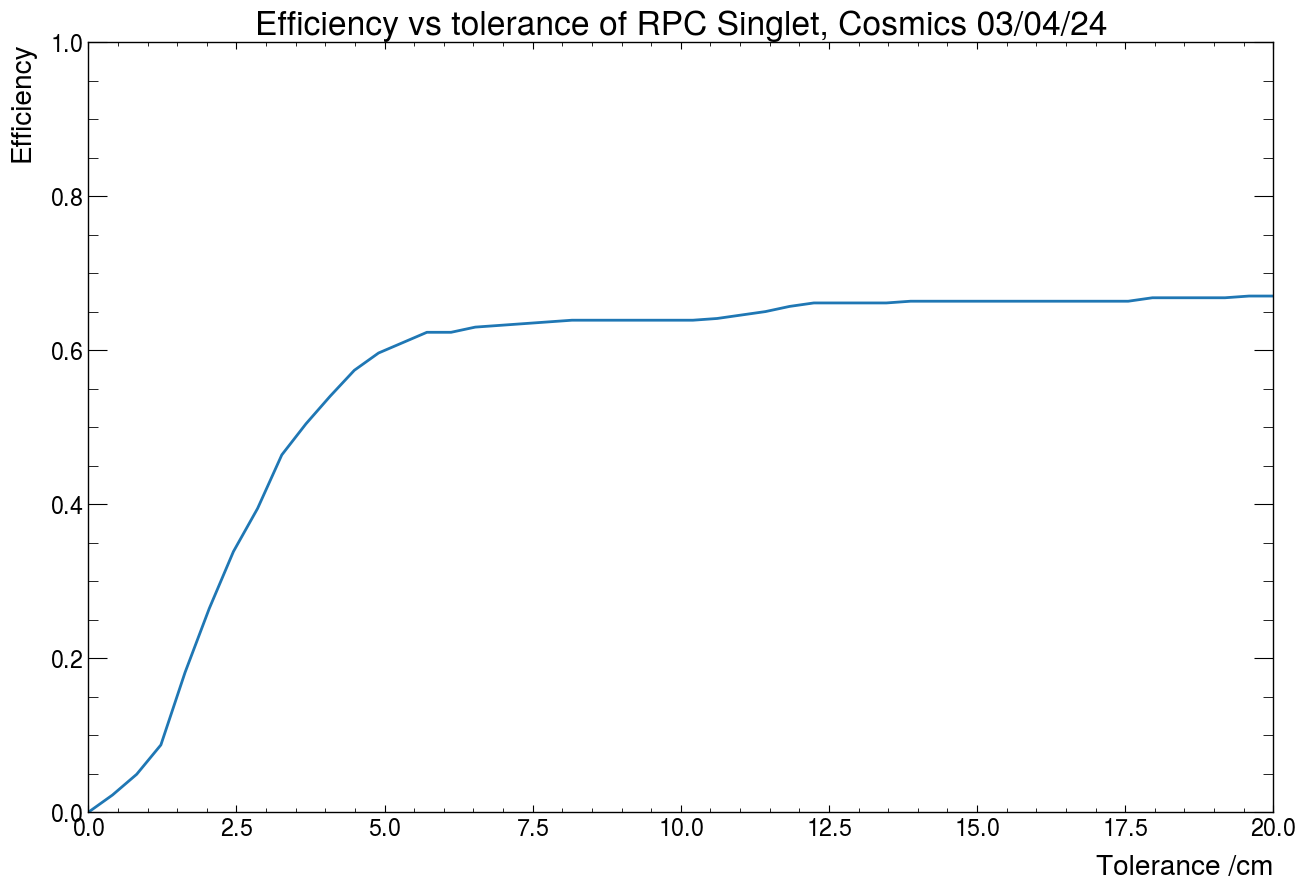

In [54]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics2_4 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics2_4.append(calc_efficiency_RPC(coincident_hits_cosmics_clustered,3,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics2_4)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Singlet, Cosmics 03/04/24')


0.0
624
0
0.40816326530612246
624
25
0.8163265306122449
624
66
1.2244897959183674
624
88
1.6326530612244898
624
137
2.0408163265306123
624
184
2.4489795918367347
624
211
2.857142857142857
624
229
3.2653061224489797
624
240
3.673469387755102
624
256
4.081632653061225
624
261
4.4897959183673475
624
261
4.8979591836734695
624
264
5.3061224489795915
624
266
5.714285714285714
624
267
6.122448979591837
624
269
6.530612244897959
624
270
6.938775510204081
624
270
7.346938775510204
624
272
7.755102040816327
624
275
8.16326530612245
624
275
8.571428571428571
624
275
8.979591836734695
624
275
9.387755102040817
624
276
9.795918367346939
624
276
10.204081632653061
624
276
10.612244897959183
624
276
11.020408163265307
624
276
11.428571428571429
624
277
11.83673469387755
624
278
12.244897959183675
624
280
12.653061224489797
624
280
13.061224489795919
624
280
13.46938775510204
624
280
13.877551020408163
624
280
14.285714285714286
624
281
14.693877551020408
624
281
15.10204081632653
624
281
15.51020408

Text(0.5, 1.0, 'Efficiency vs tolerance of RPC Doublet Low, Cosmics 03/04/24')

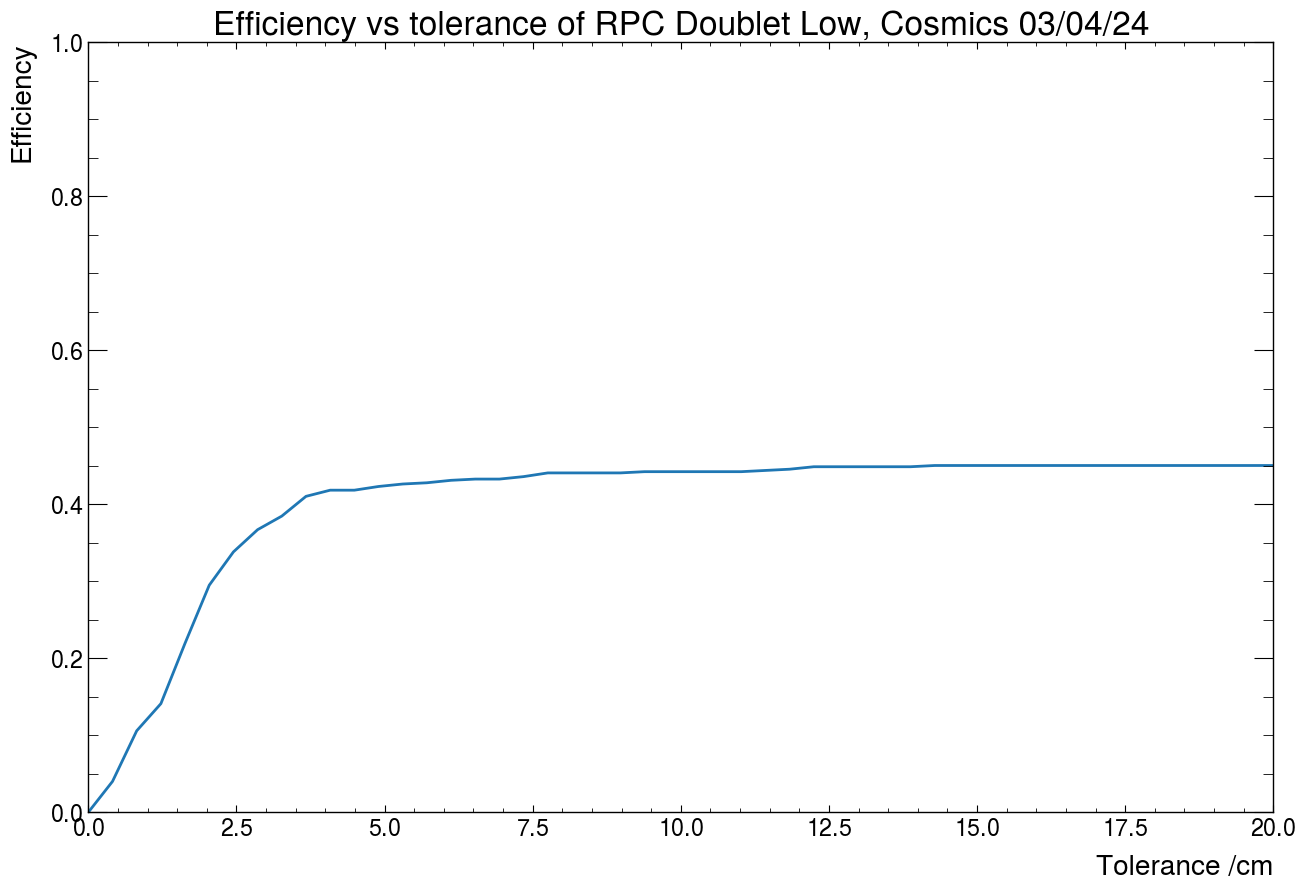

In [55]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics2_5 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics2_5.append(calc_efficiency_RPC(coincident_hits_cosmics_clustered,4,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics2_5)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Doublet Low, Cosmics 03/04/24')


0.0
723
0
0.40816326530612246
723
19
0.8163265306122449
723
61
1.2244897959183674
723
122
1.6326530612244898
723
179
2.0408163265306123
723
214
2.4489795918367347
723
249
2.857142857142857
723
253
3.2653061224489797
723
259
3.673469387755102
723
262
4.081632653061225
723
265
4.4897959183673475
723
269
4.8979591836734695
723
271
5.3061224489795915
723
273
5.714285714285714
723
274
6.122448979591837
723
275
6.530612244897959
723
275
6.938775510204081
723
275
7.346938775510204
723
275
7.755102040816327
723
277
8.16326530612245
723
277
8.571428571428571
723
277
8.979591836734695
723
278
9.387755102040817
723
278
9.795918367346939
723
278
10.204081632653061
723
278
10.612244897959183
723
278
11.020408163265307
723
279
11.428571428571429
723
279
11.83673469387755
723
279
12.244897959183675
723
279
12.653061224489797
723
281
13.061224489795919
723
281
13.46938775510204
723
281
13.877551020408163
723
281
14.285714285714286
723
281
14.693877551020408
723
281
15.10204081632653
723
281
15.5102040

Text(0.5, 1.0, 'Efficiency vs tolerance of RPC Doublet High, Cosmics 03/04/24')

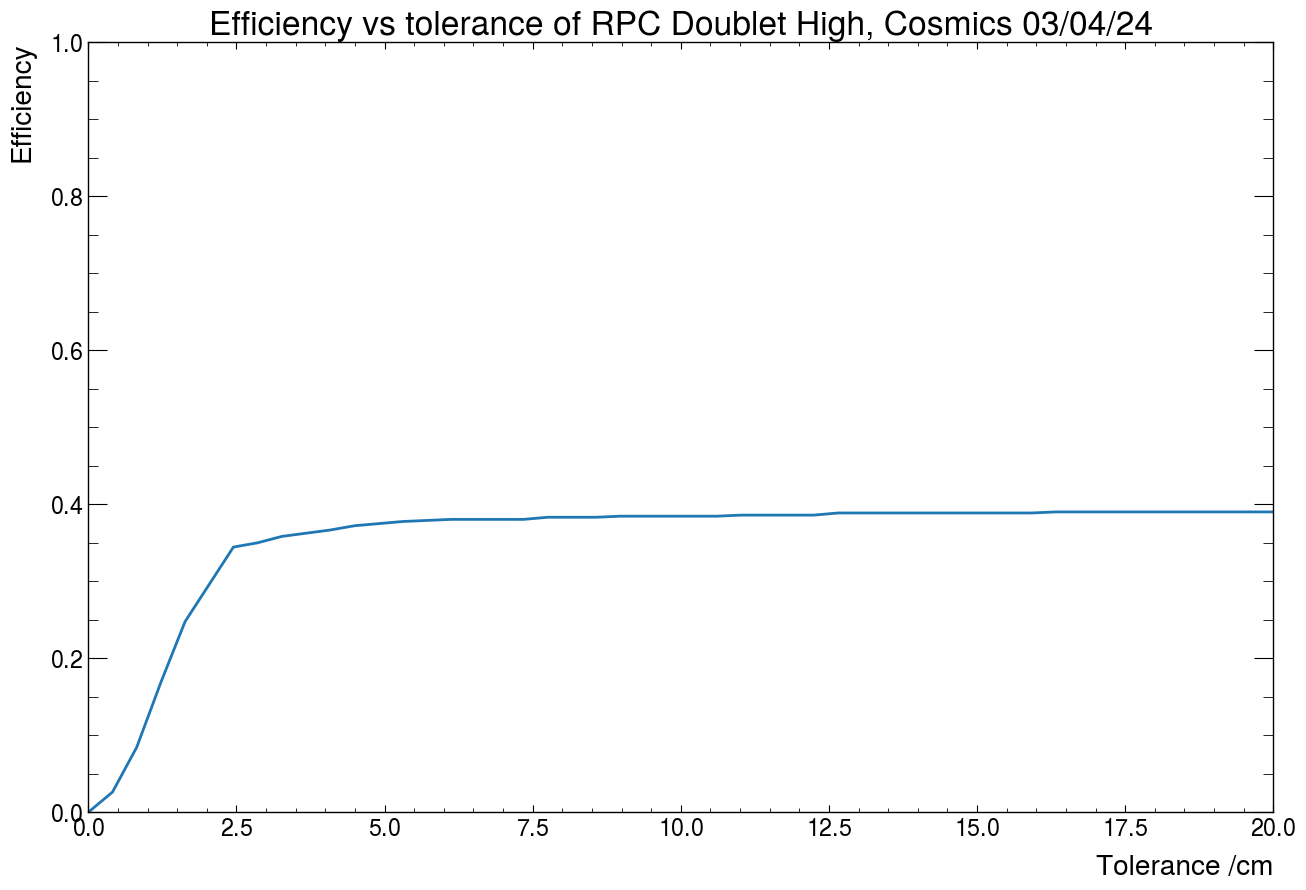

In [56]:
tolerances = np.linspace(0,20,50)

efficiences_cosmics2_6 = []

for tol in tolerances:
    print(tol)
    efficiences_cosmics2_6.append(calc_efficiency_RPC(coincident_hits_cosmics_clustered,5,tol))

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics2_6)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Doublet High, Cosmics 03/04/24')


In [ ]:
plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiences_cosmics2_6, label= 'Cosmics 04/04/24')
plt.plot(tolerances, efficiences6, label= 'Luminosity spike 04/04/24')
plt.plot(tolerances, efficiences_cosmics6, label= 'Cosmics 24_03_01')

plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')

plt.legend()
plt.ylim(0,1)

plt.title('Efficiency vs tolerance, RPC Doublet High')

plt.show()

Combined Plots

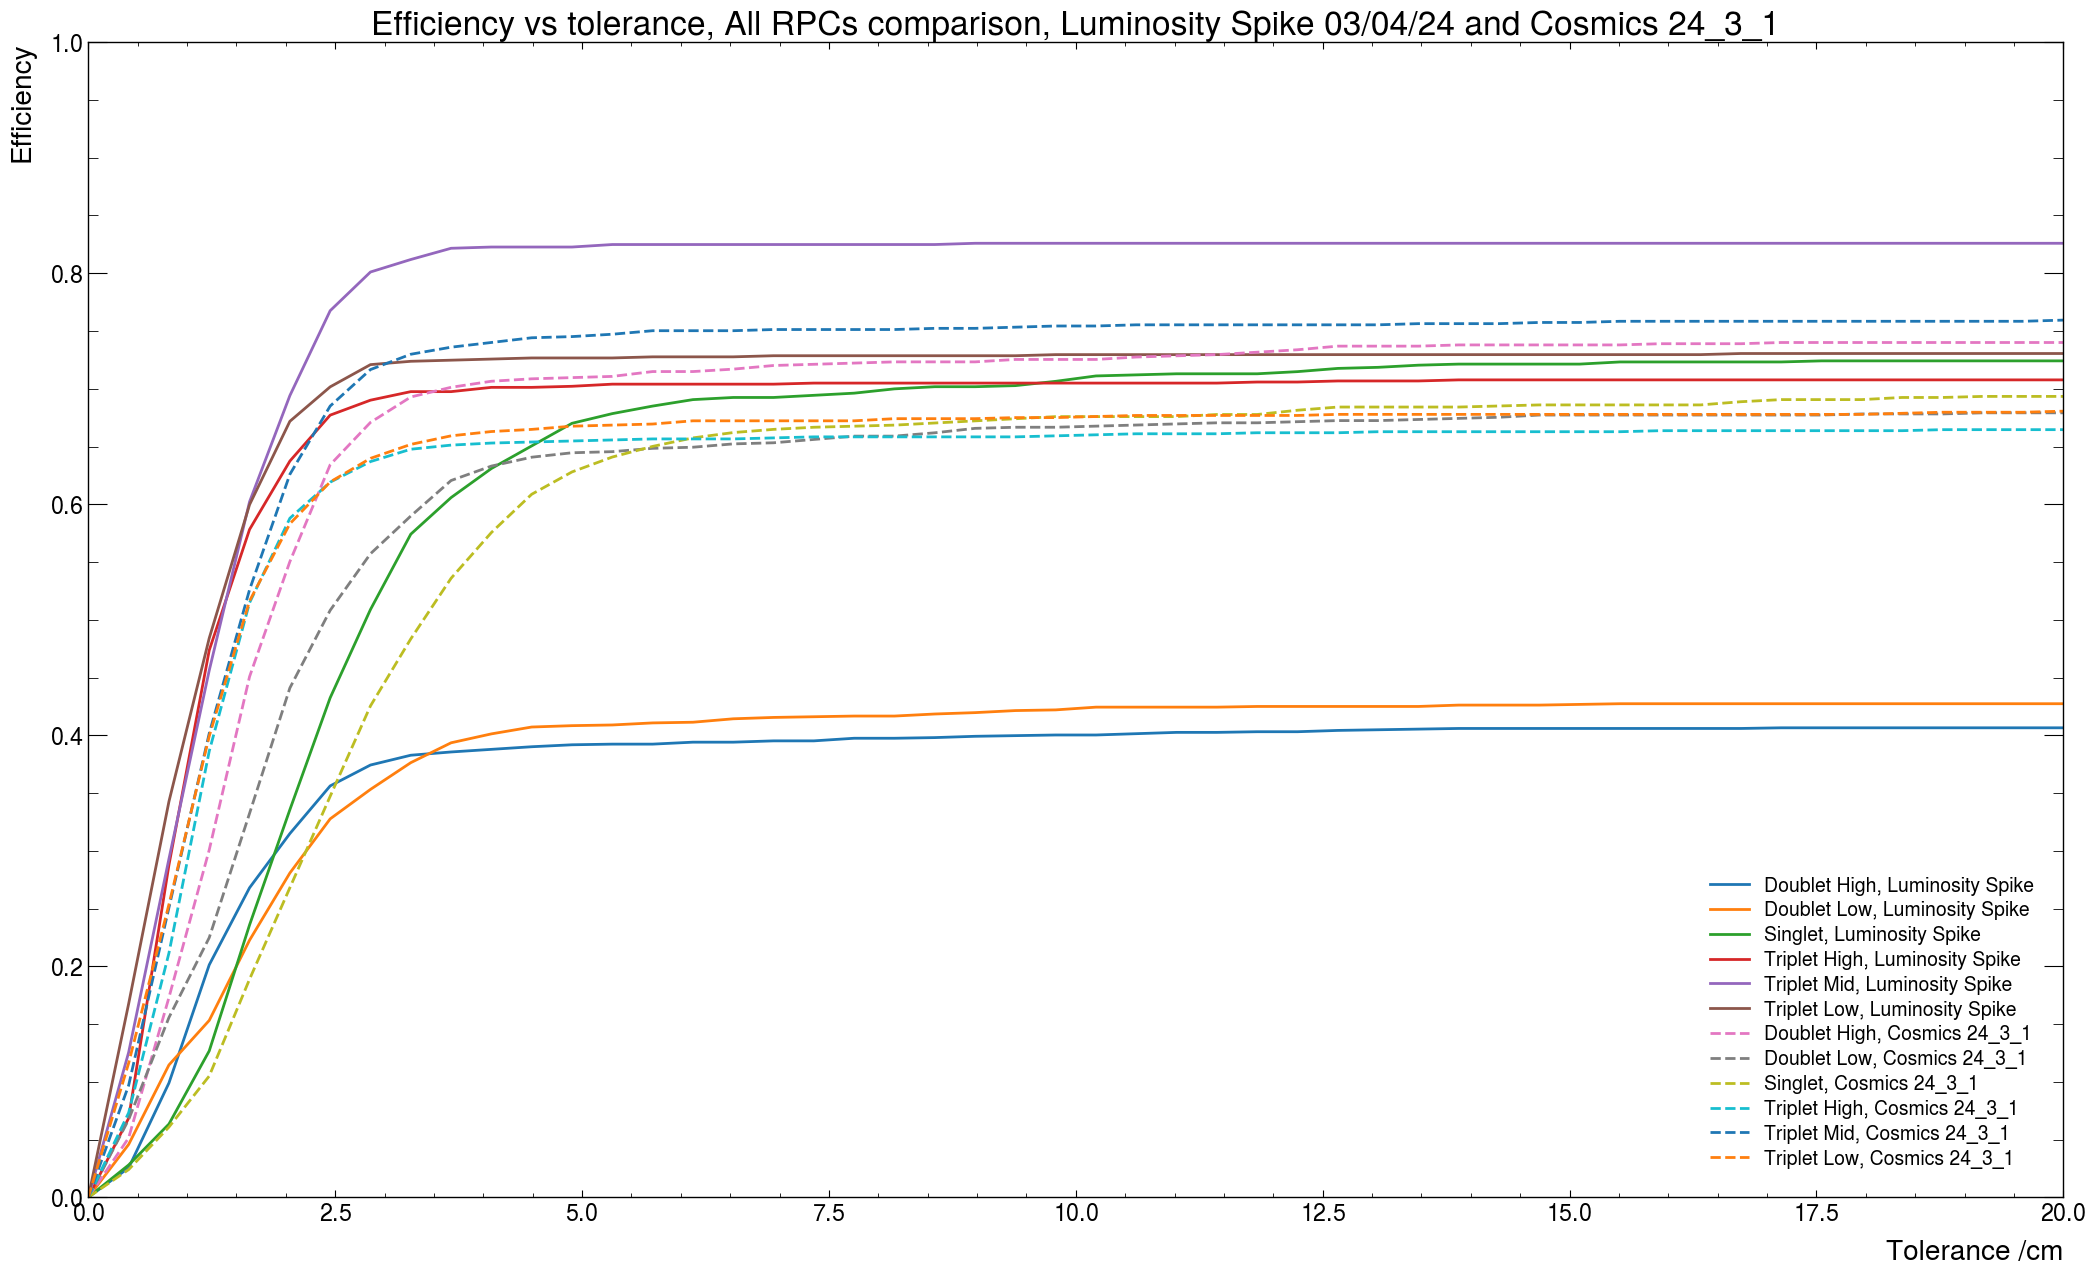

In [72]:
plt.figure(figsize=(25,15))

plt.plot(tolerances, efficiences6, label= 'Doublet High, Luminosity Spike')
plt.plot(tolerances, efficiences5, label= 'Doublet Low, Luminosity Spike')
plt.plot(tolerances, efficiences4, label= 'Singlet, Luminosity Spike')
plt.plot(tolerances, efficiences3, label= 'Triplet High, Luminosity Spike')
plt.plot(tolerances, efficiences2, label= 'Triplet Mid, Luminosity Spike')
plt.plot(tolerances, efficiences1, label= 'Triplet Low, Luminosity Spike')
plt.plot(tolerances, efficiences_cosmics6, label= 'Doublet High, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics5, label= 'Doublet Low, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics4, label= 'Singlet, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics3, label= 'Triplet High, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics2, label= 'Triplet Mid, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics1, label= 'Triplet Low, Cosmics 24_3_1',linestyle='dashed')
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')

plt.legend()
plt.ylim(0,1)

plt.title('Efficiency vs tolerance, All RPCs comparison, Luminosity Spike 03/04/24 and Cosmics 24_3_1')

plt.show()

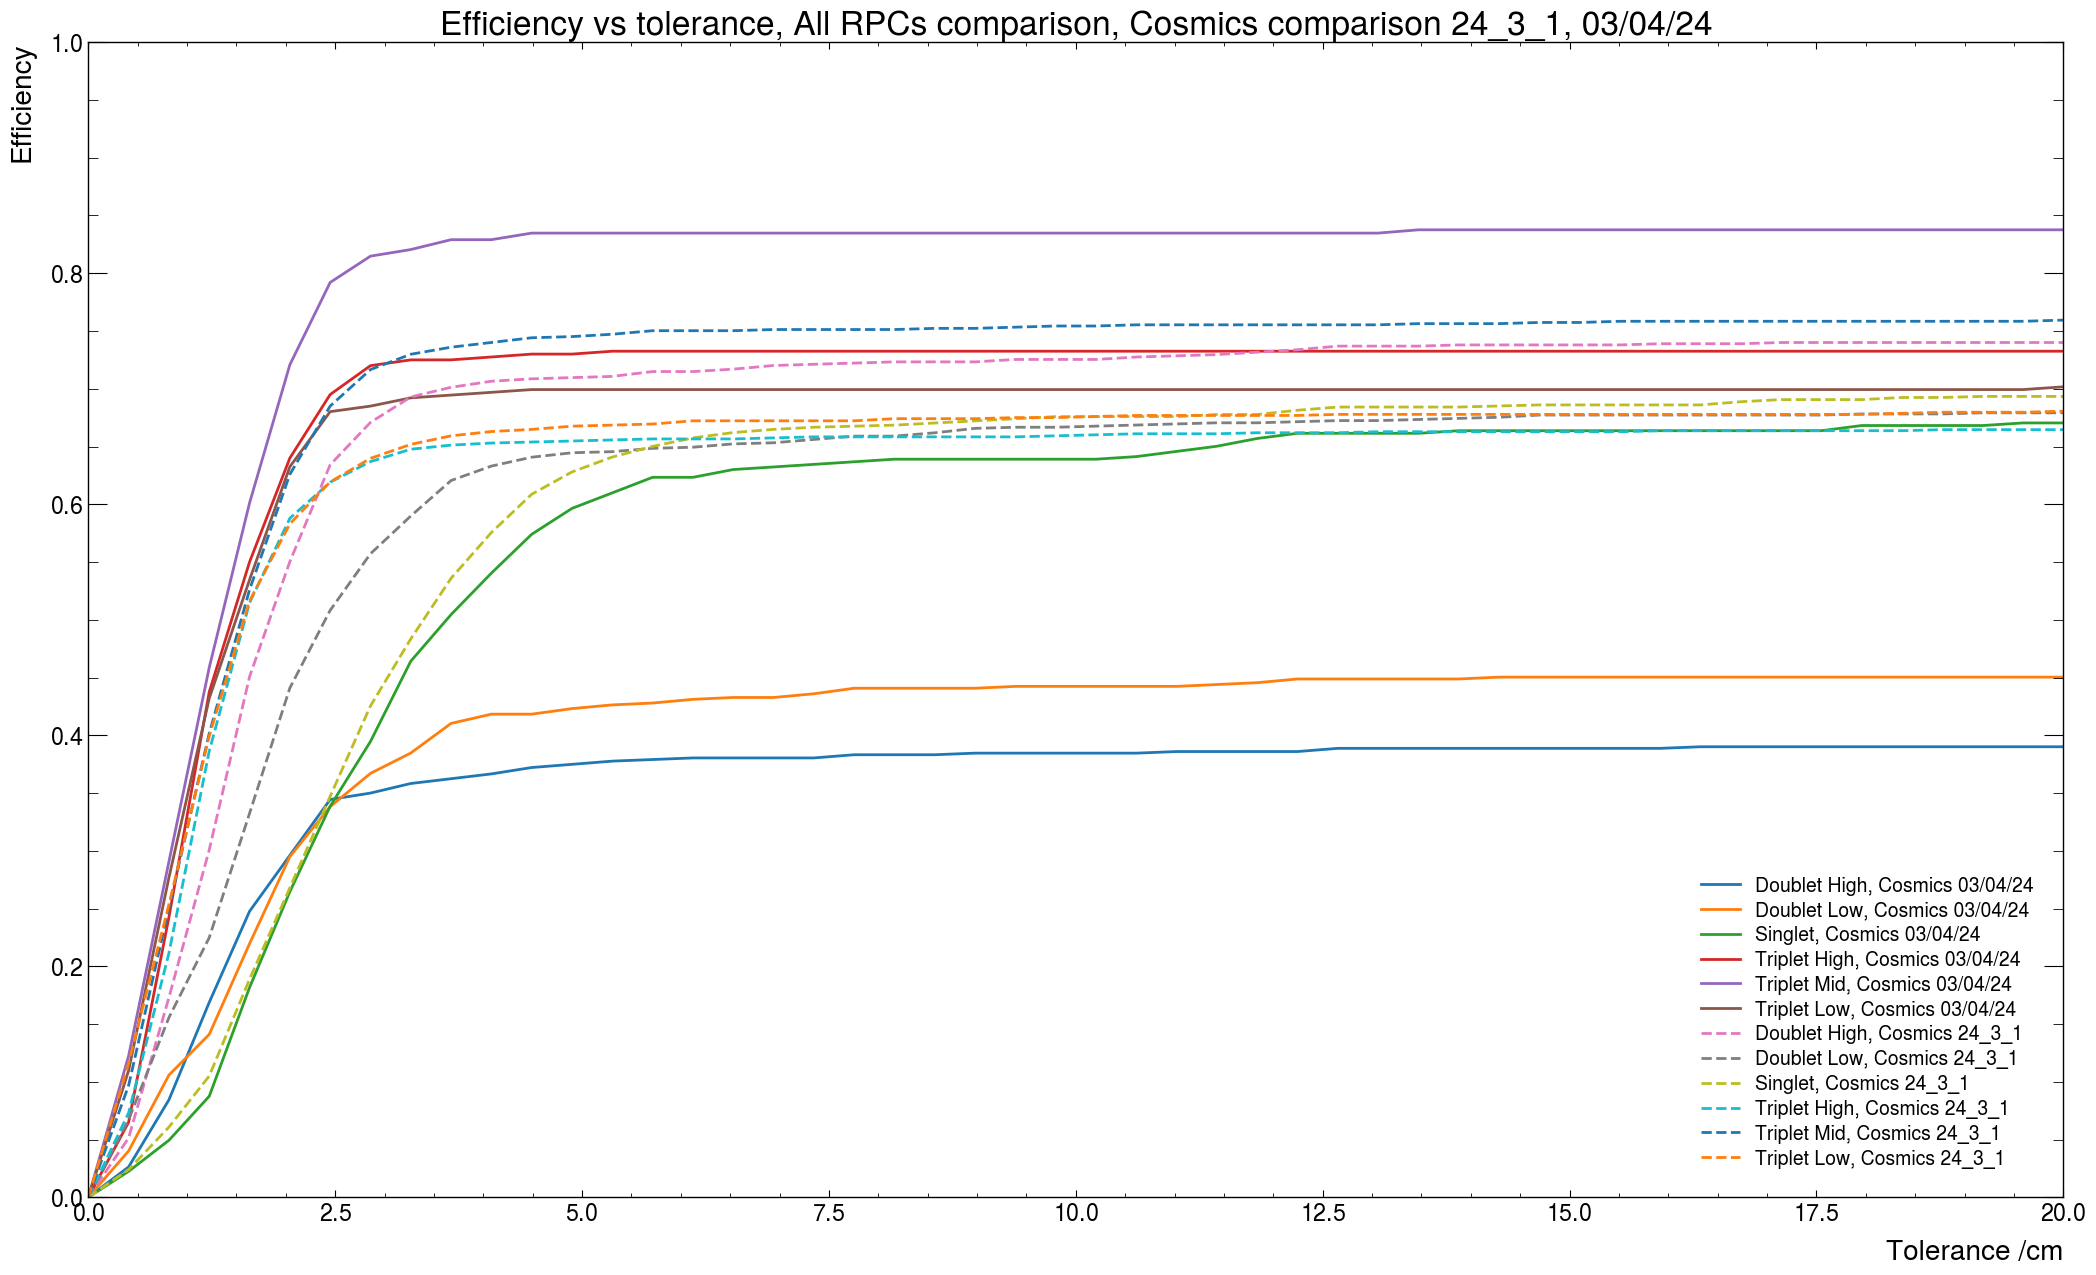

In [74]:
plt.figure(figsize=(25,15))

plt.plot(tolerances, efficiences_cosmics2_6, label= 'Doublet High, Cosmics 03/04/24')
plt.plot(tolerances, efficiences_cosmics2_5, label= 'Doublet Low, Cosmics 03/04/24')
plt.plot(tolerances, efficiences_cosmics2_4, label= 'Singlet, Cosmics 03/04/24')
plt.plot(tolerances, efficiences_cosmics2_3, label= 'Triplet High, Cosmics 03/04/24')
plt.plot(tolerances, efficiences_cosmics2_2, label= 'Triplet Mid, Cosmics 03/04/24')
plt.plot(tolerances, efficiences_cosmics2_1, label= 'Triplet Low, Cosmics 03/04/24')
plt.plot(tolerances, efficiences_cosmics6, label= 'Doublet High, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics5, label= 'Doublet Low, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics4, label= 'Singlet, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics3, label= 'Triplet High, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics2, label= 'Triplet Mid, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics1, label= 'Triplet Low, Cosmics 24_3_1',linestyle='dashed')
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')

plt.legend()
plt.ylim(0,1)

plt.title('Efficiency vs tolerance, All RPCs comparison, Cosmics comparison 24_3_1, 03/04/24')

plt.show()

In [ ]:
plt.figure(figsize=(25,15))

plt.plot(tolerances, efficiences6, label= 'Doublet High, Luminosity Spike')
plt.plot(tolerances, efficiences5, label= 'Doublet Low, Luminosity Spike')
plt.plot(tolerances, efficiences4, label= 'Singlet, Luminosity Spike')
plt.plot(tolerances, efficiences3, label= 'Triplet High, Luminosity Spike')
plt.plot(tolerances, efficiences2, label= 'Triplet Mid, Luminosity Spike')
plt.plot(tolerances, efficiences1, label= 'Triplet Low, Luminosity Spike')
plt.plot(tolerances, efficiences_cosmics6, label= 'Doublet High, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics5, label= 'Doublet Low, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics4, label= 'Singlet, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics3, label= 'Triplet High, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics2, label= 'Triplet Mid, Cosmics 24_3_1',linestyle='dashed')
plt.plot(tolerances, efficiences_cosmics1, label= 'Triplet Low, Cosmics 24_3_1',linestyle='dashed')
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')

plt.legend()
plt.ylim(0,1)

plt.title('Efficiency vs tolerance, All RPCs comparison, Cosmics comparison 24_3_1, 03/04/24')

plt.show()